In [ ]:
import shutil
import os
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS
import matplotlib.pyplot as plt
import torch.nn.functional as F
import librosa
import cv2
import numpy as np
from IPython.display import Audio
from PIL import Image
import soundfile as sf
import torch.nn
import torchaudio.functional as F
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [ ]:
transform_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)

In [ ]:
def plot_spectrogram_pt(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(transform_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [ ]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [ ]:
def plot_spectrogram_raw(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

In [ ]:
class WavToMel(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=2)

        self.mel_scale = torchaudio.transforms.MelScale(
            n_mels=n_mel, sample_rate=resample_freq, n_stft=n_fft // 2 + 1)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spec(waveform)
        # spec = torch.from_numpy(librosa.power_to_db(spec))
        mel = self.mel_scale(spec)
        mel = torch.from_numpy(librosa.power_to_db(mel))

        return mel

Invert Mel to Audio

In [ ]:
class MelToWav(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.inverseMel = torchaudio.transforms.InverseMelScale(n_stft = n_fft // 2 + 1 , n_mels = 32, sample_rate = 16000)

        self.inversespec = torchaudio.transforms.GriffinLim(n_fft)

    def forward(self, mel: torch.Tensor) -> torch.Tensor:
        mel = librosa.db_to_power(mel)
        invertedMel = self.inverseMel(mel)
        waveform = self.inversespec(invertedMel)

        return waveform

In [ ]:
mel_to_wav = MelToWav()

# Melspectograms

View all produced mel spectogram prototypes

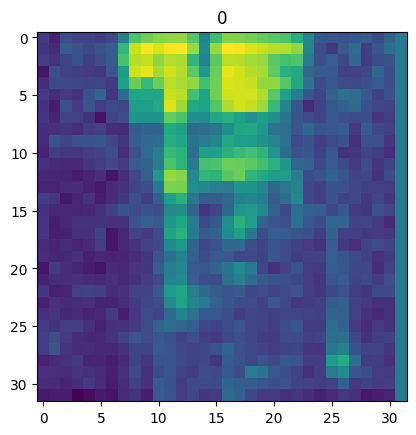

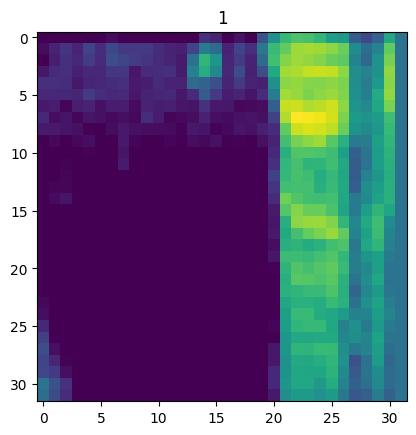

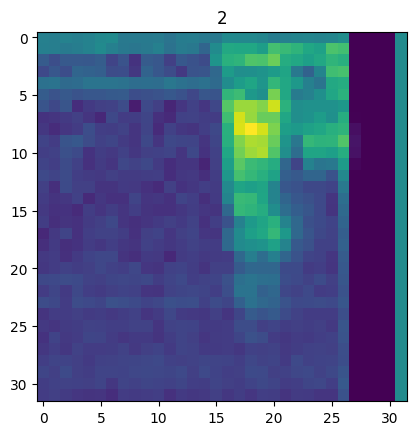

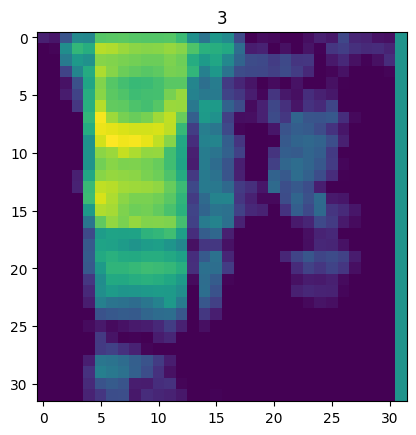

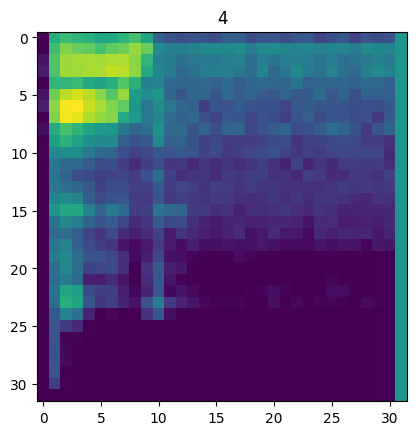

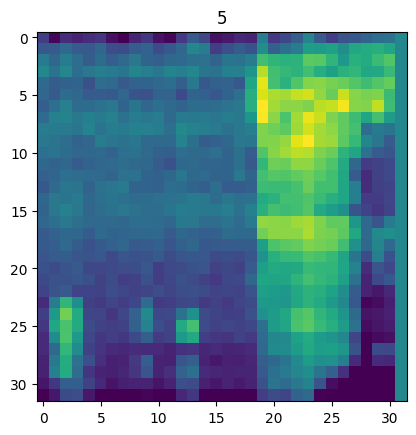

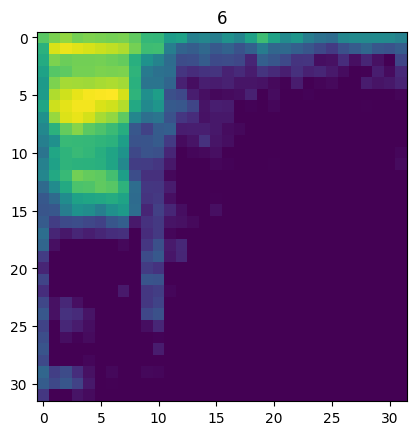

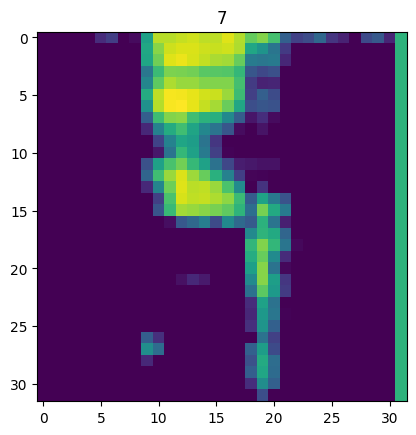

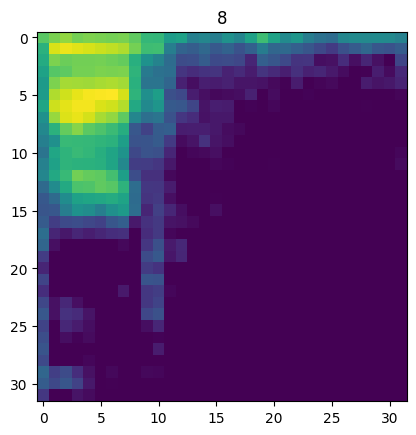

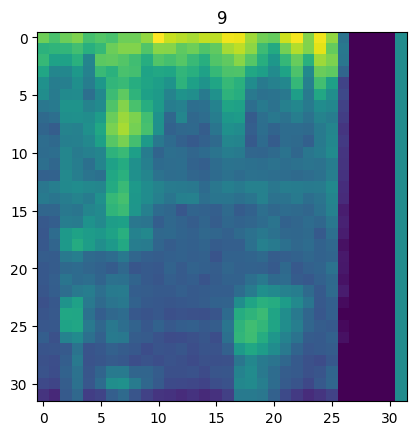

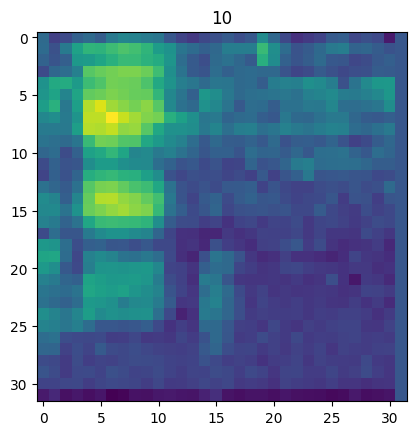

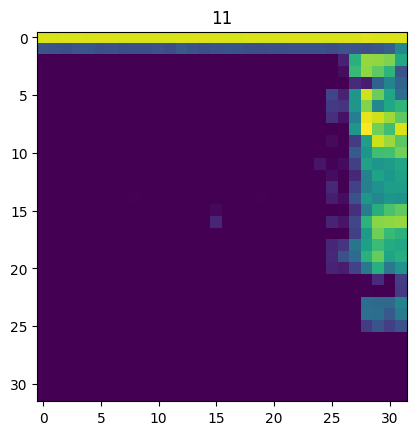

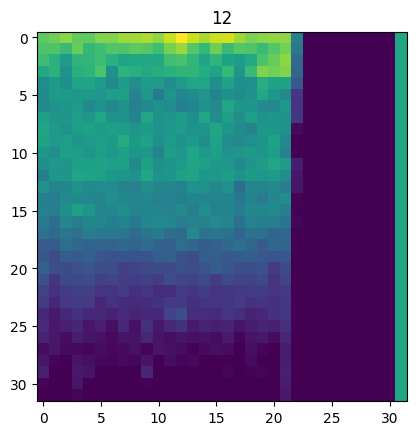

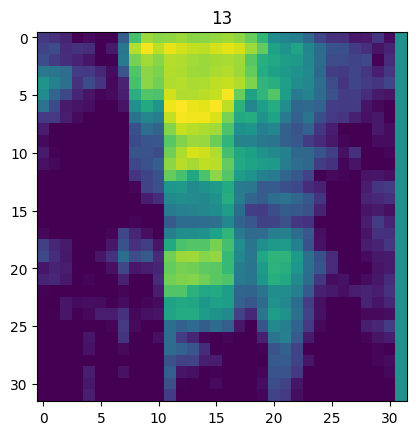

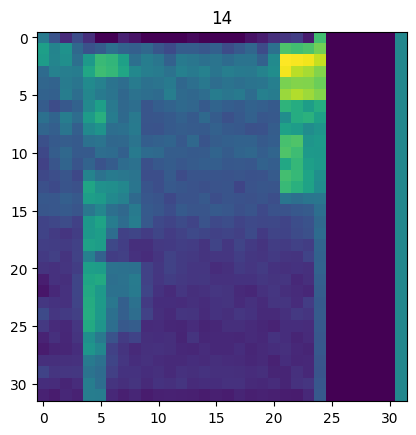

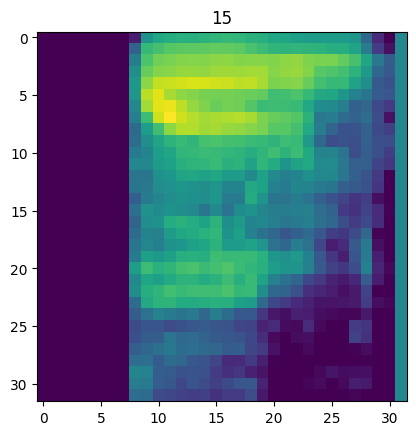

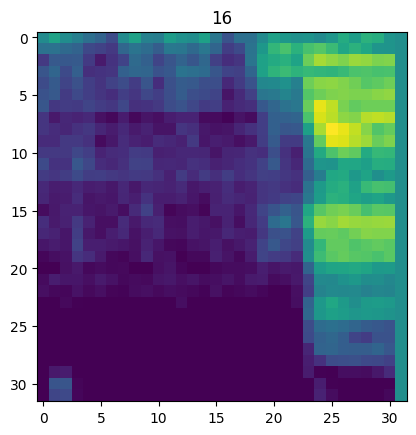

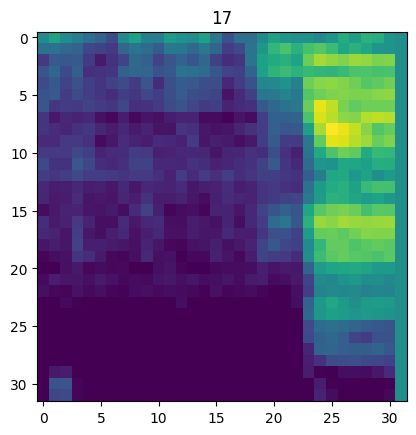

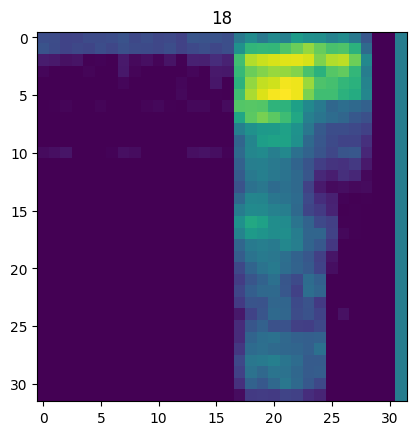

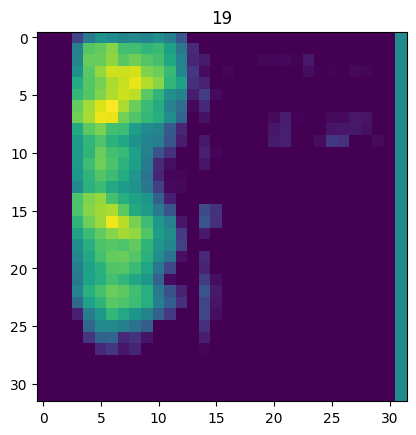

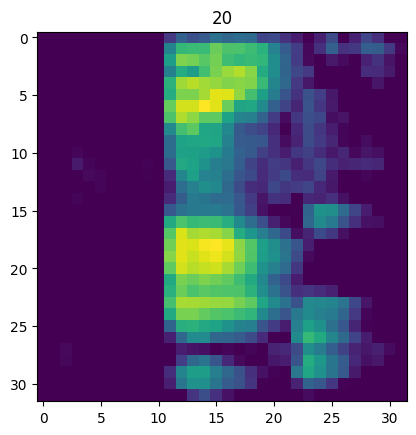

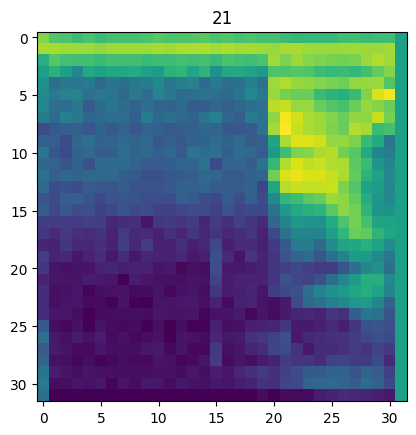

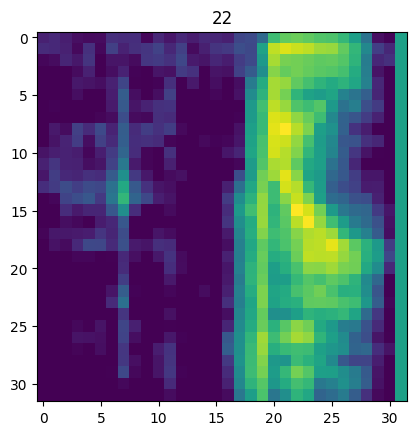

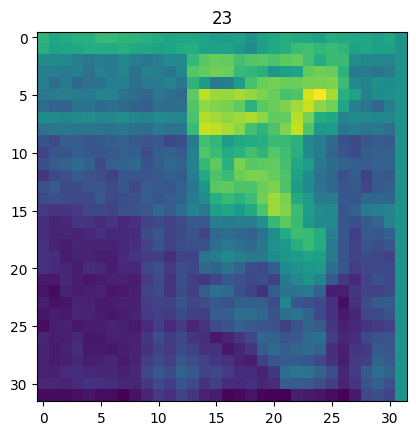

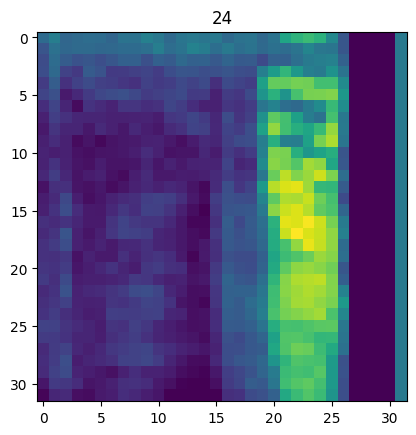

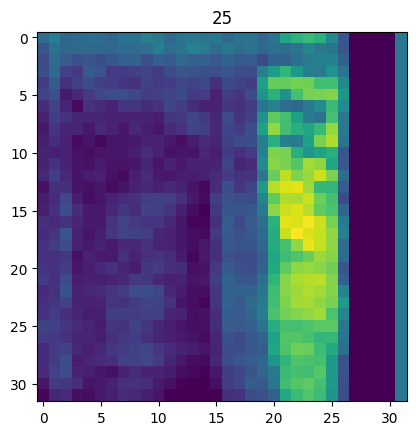

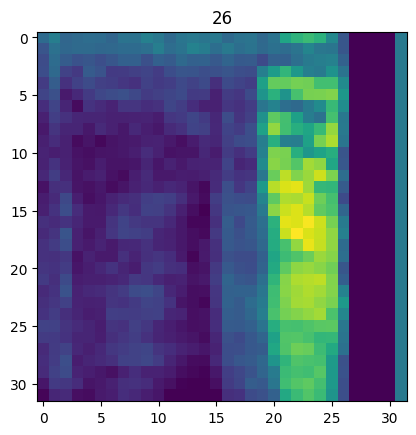

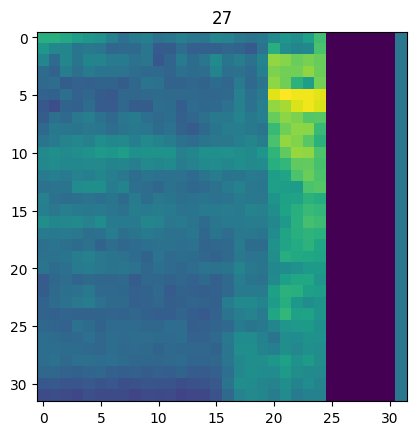

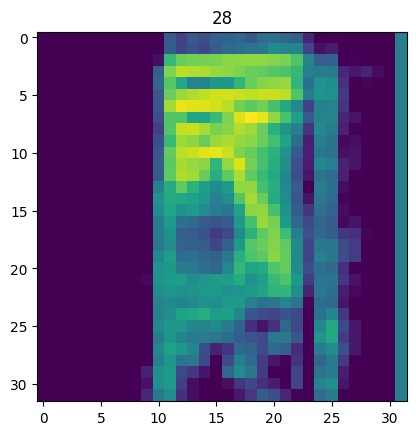

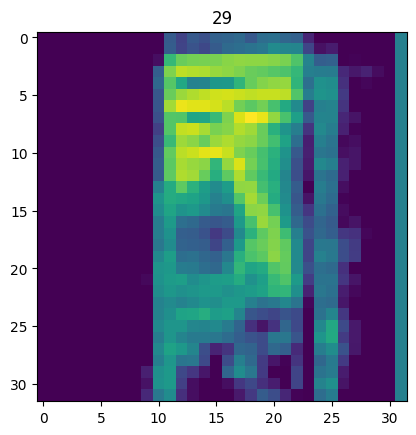

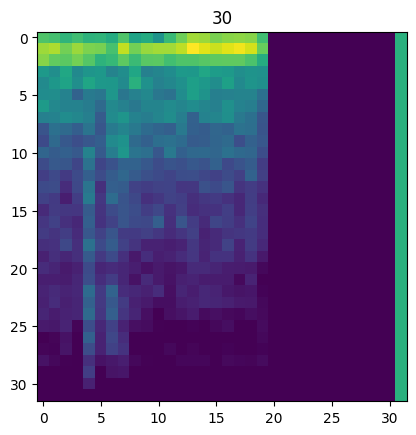

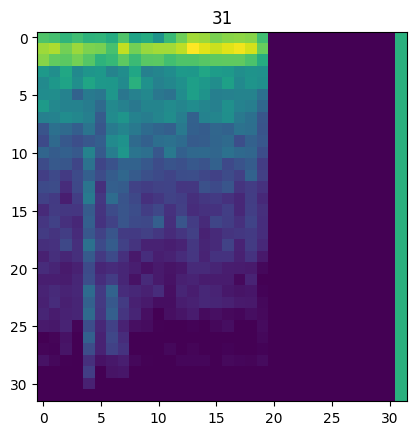

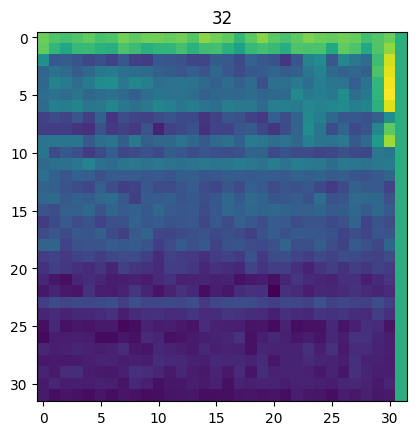

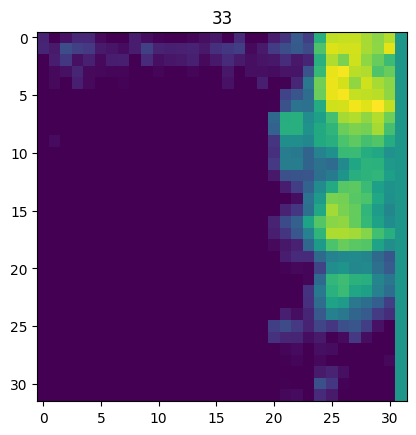

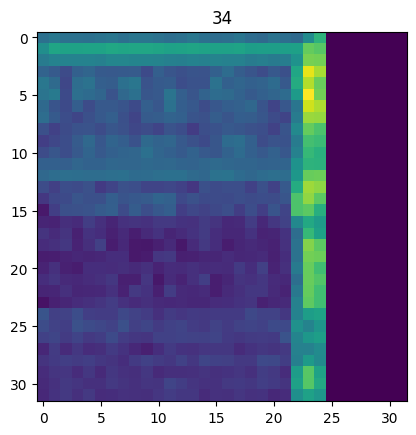

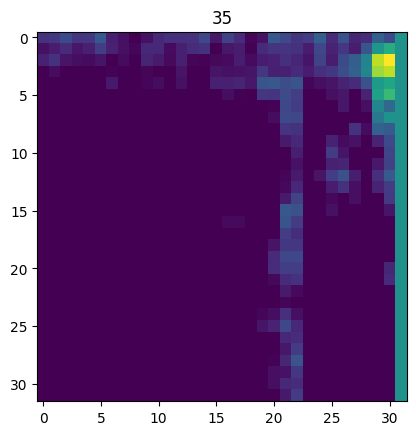

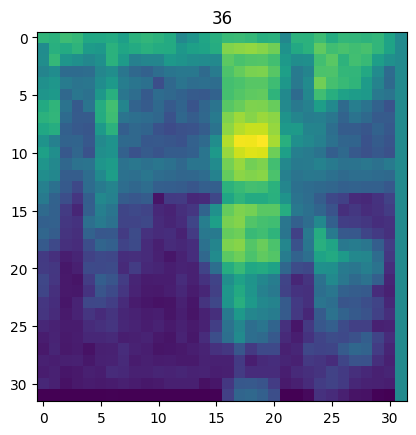

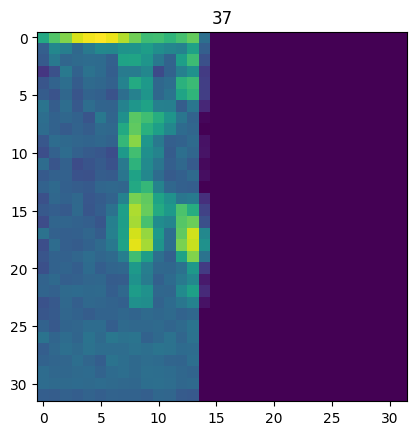

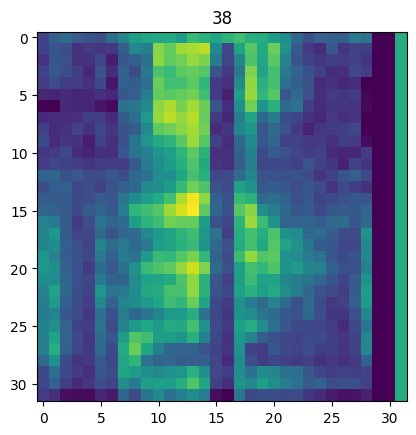

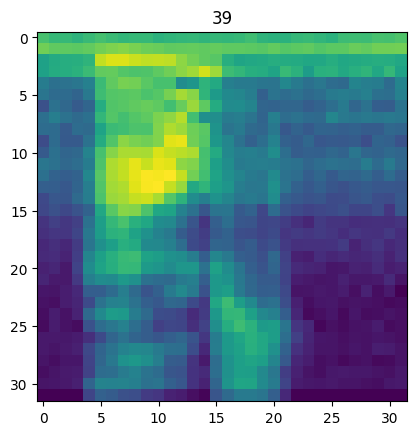

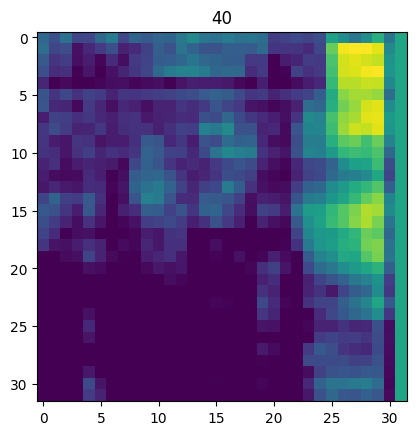

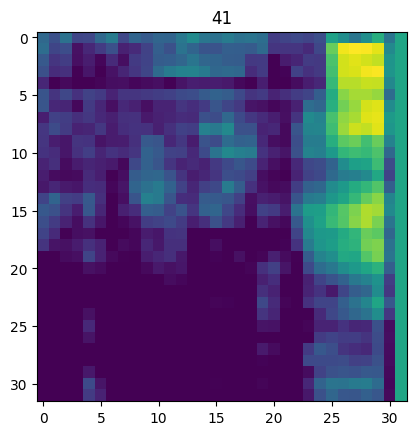

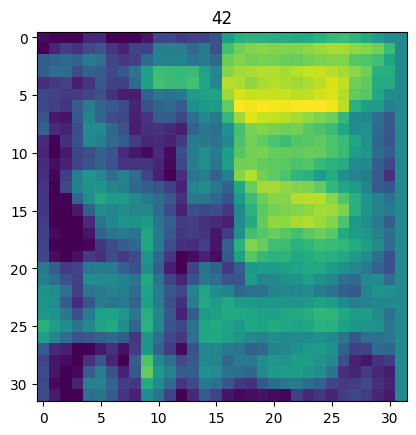

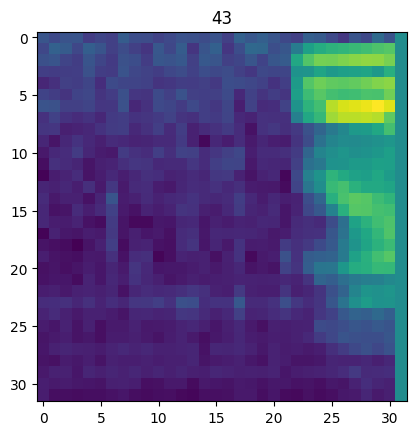

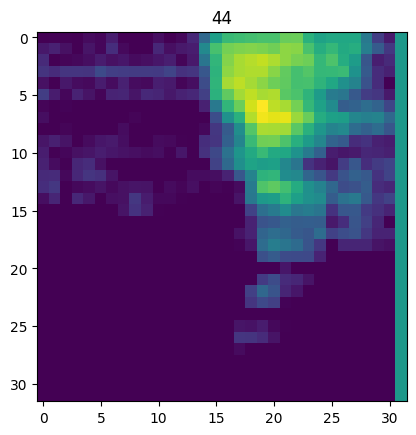

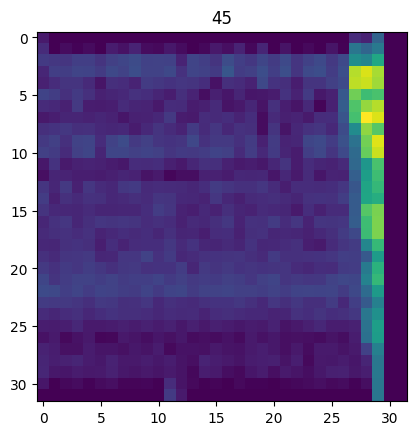

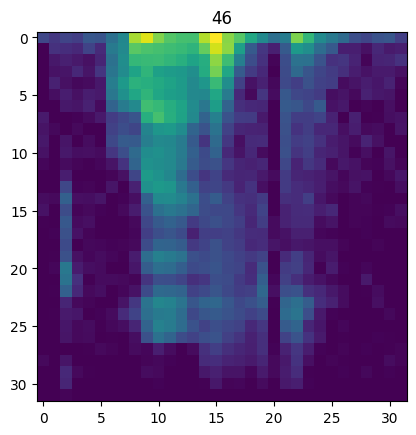

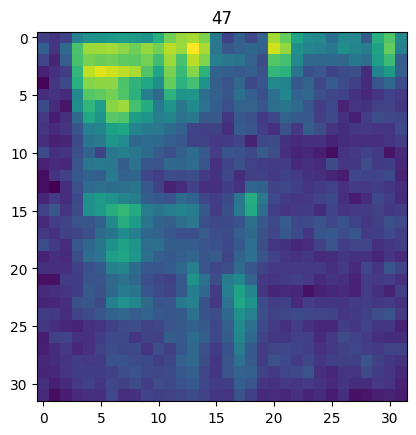

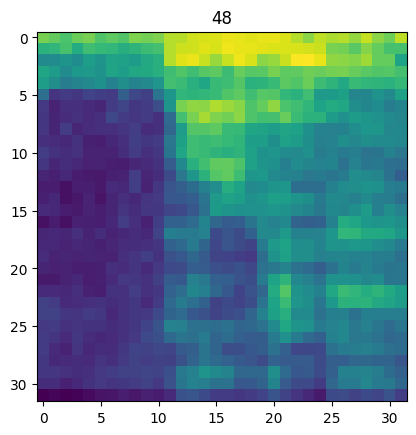

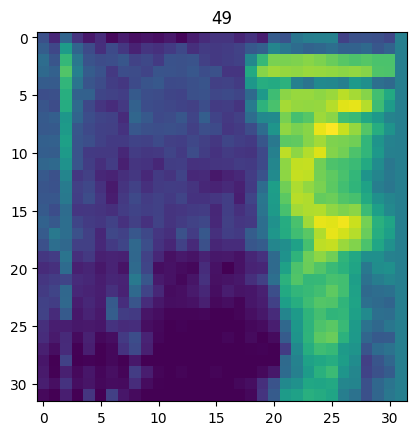

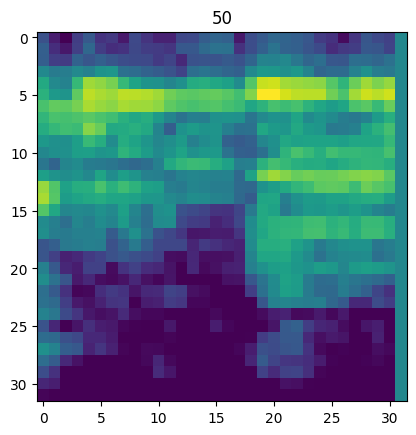

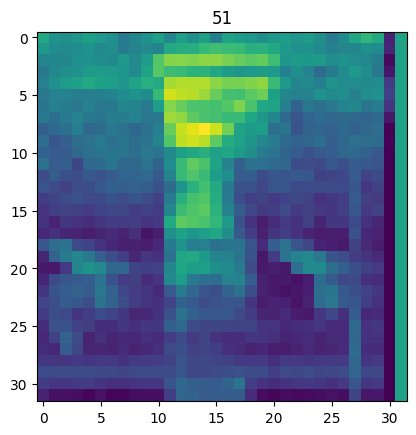

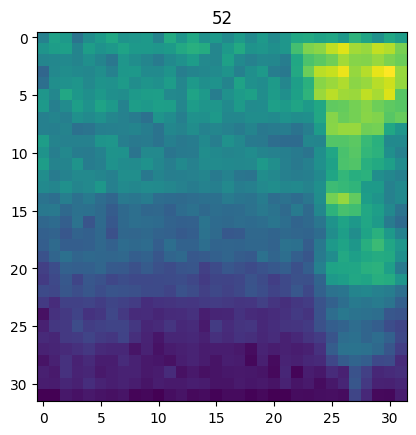

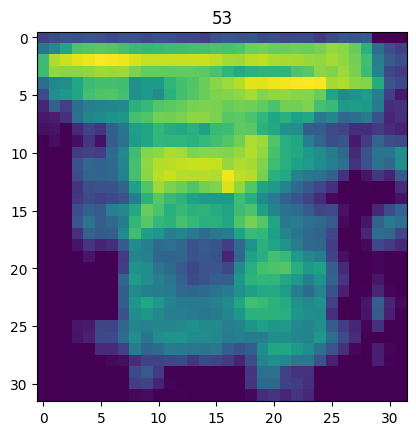

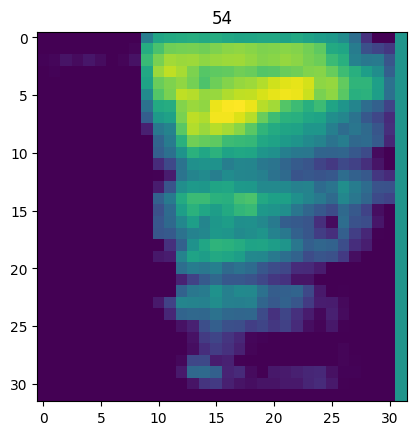

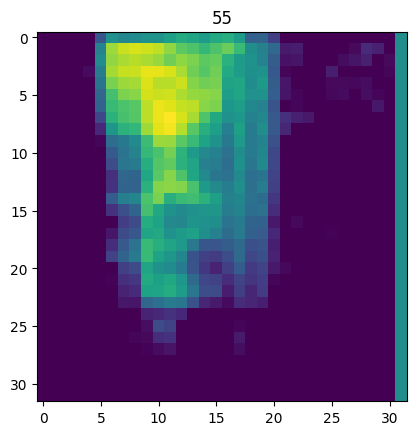

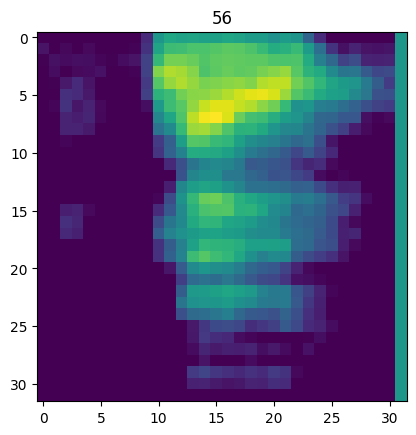

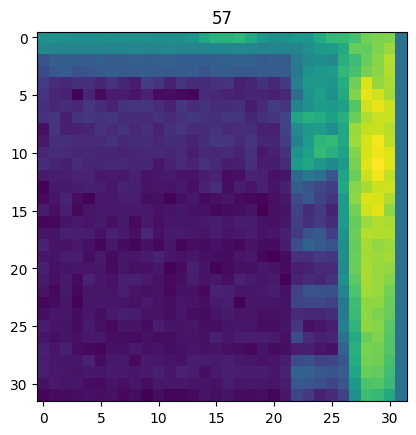

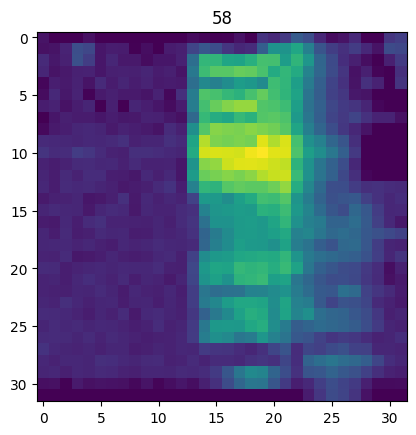

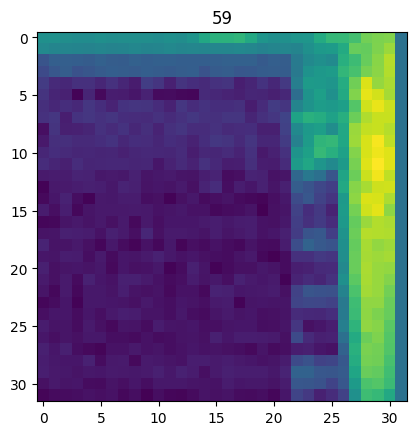

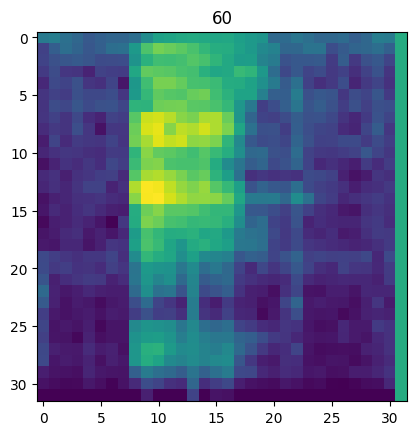

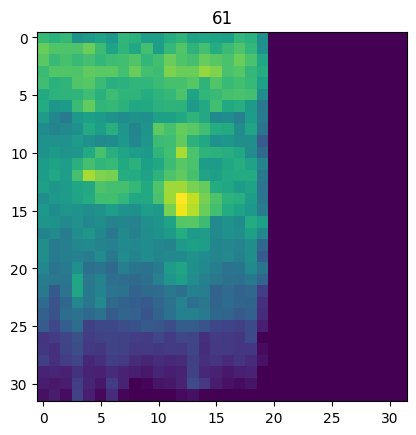

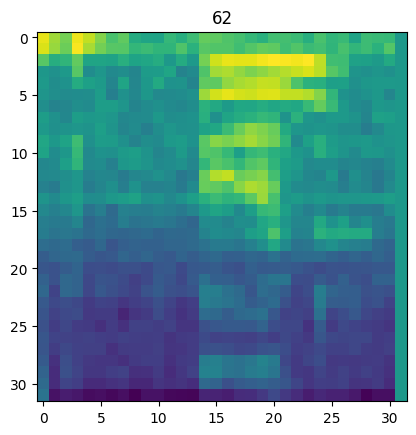

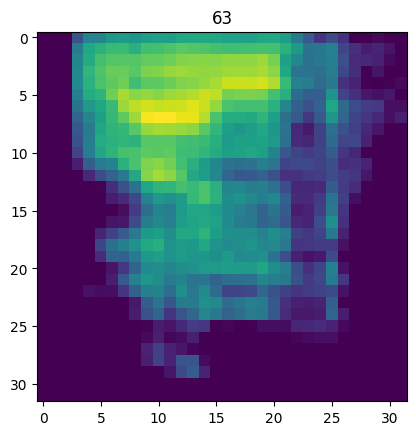

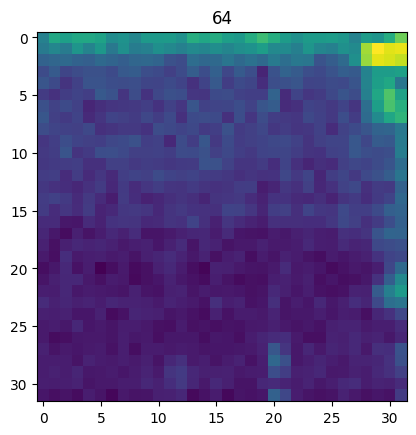

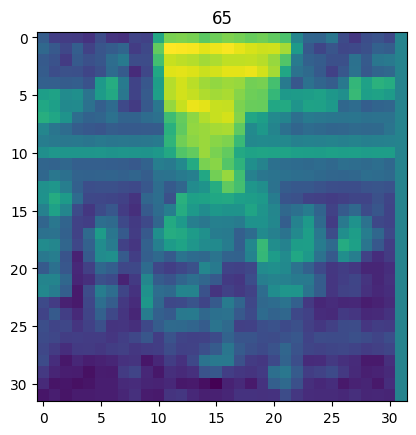

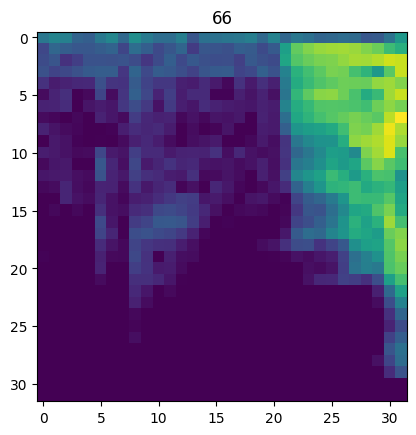

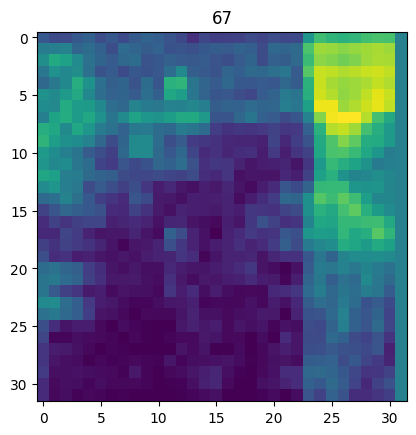

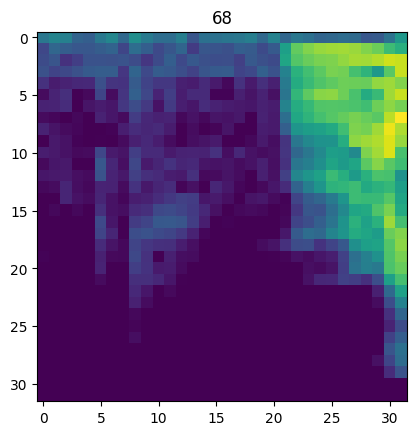

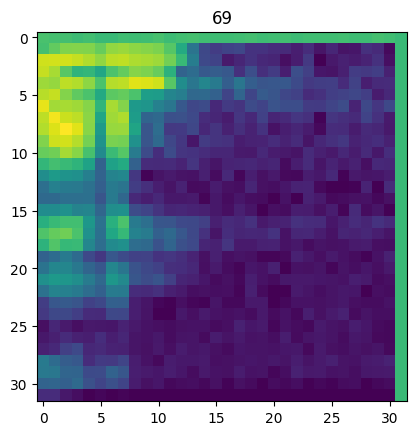

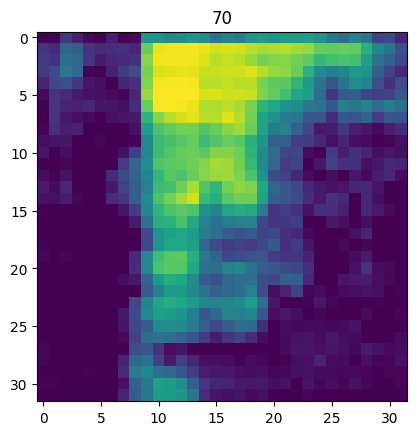

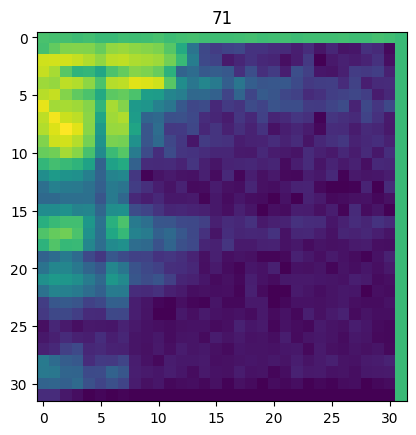

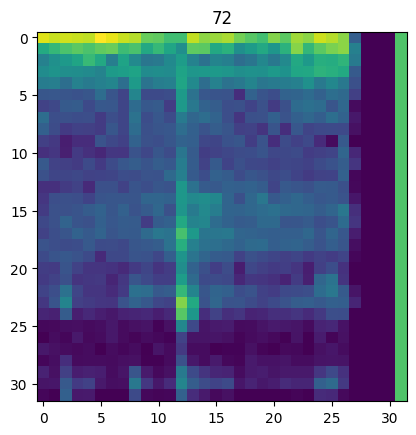

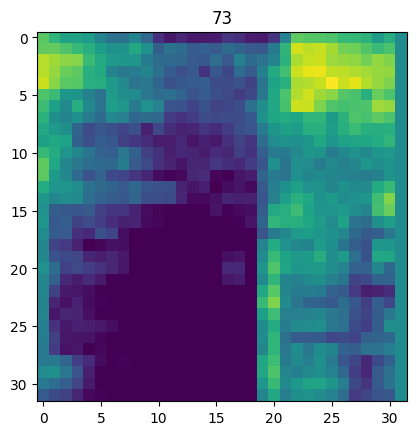

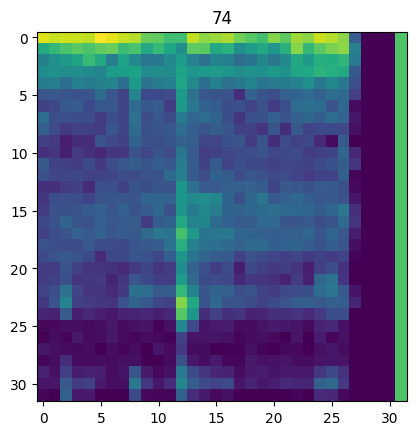

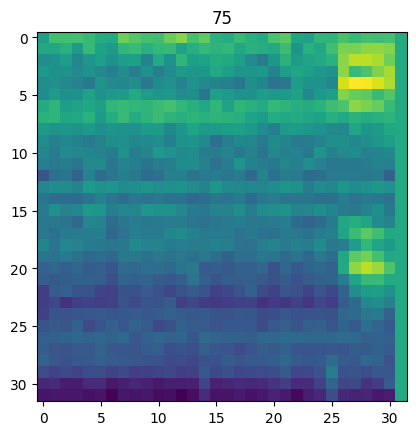

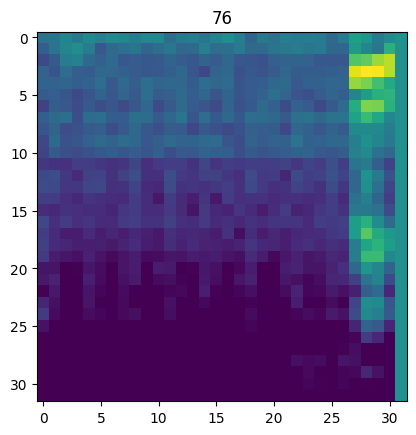

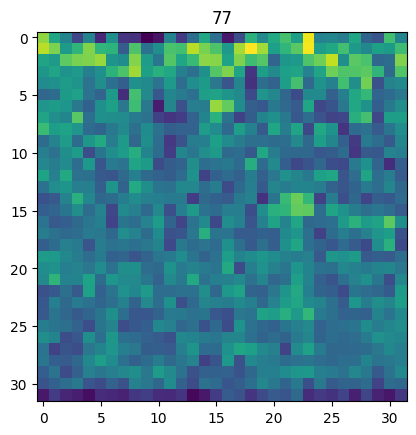

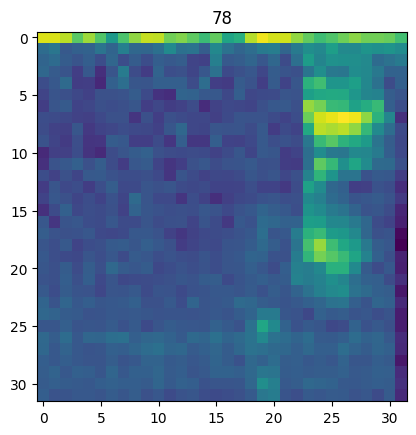

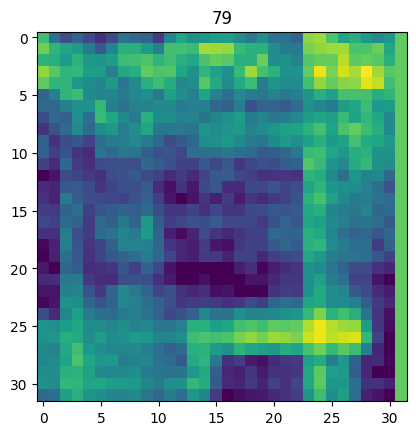

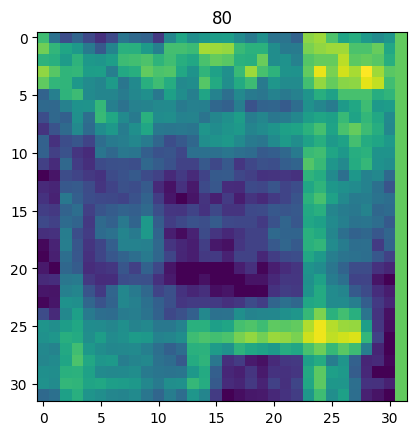

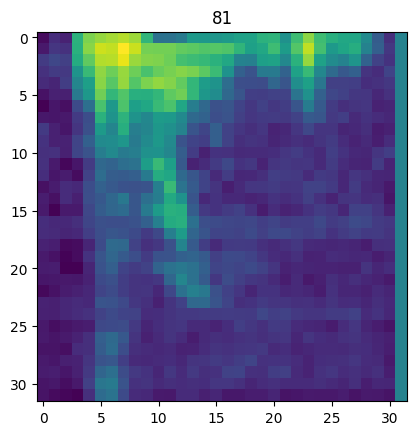

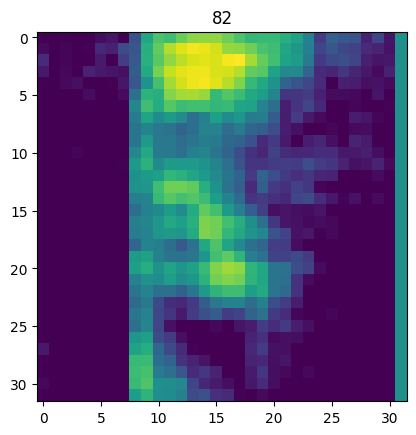

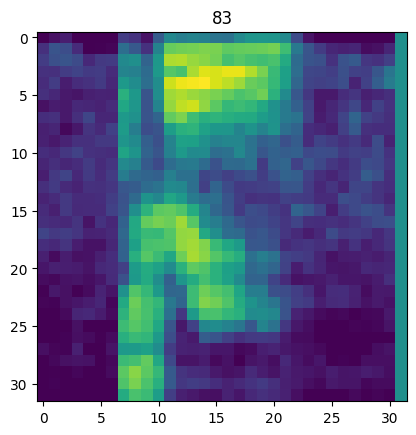

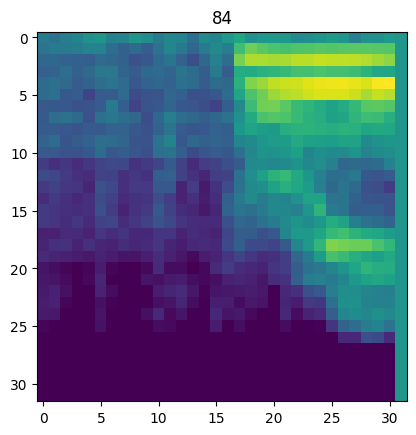

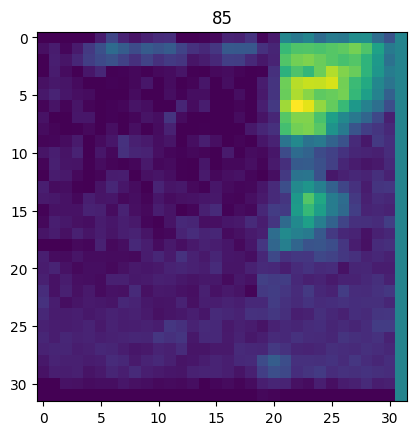

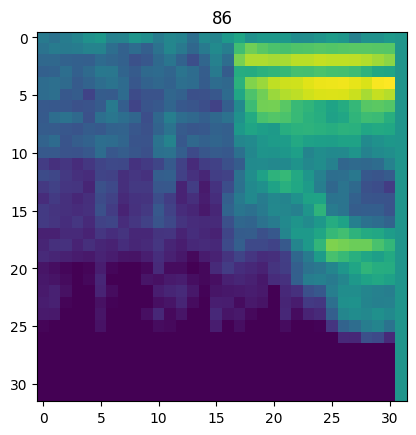

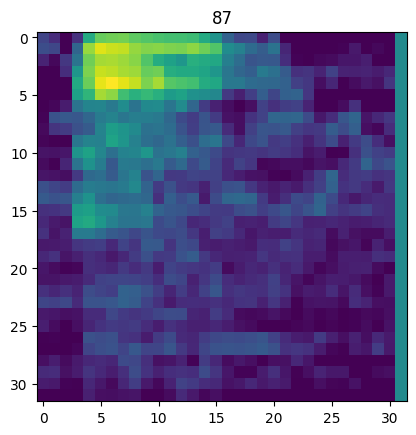

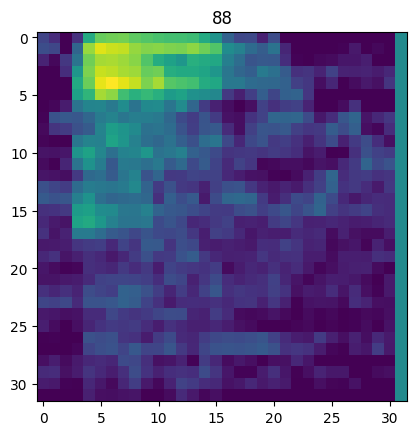

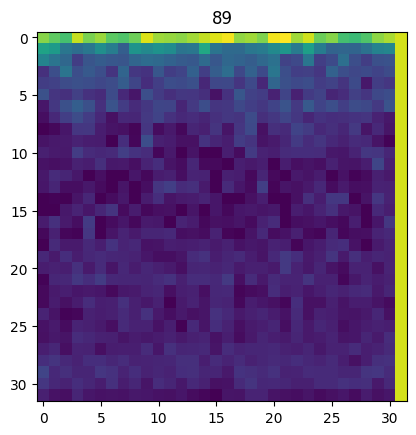

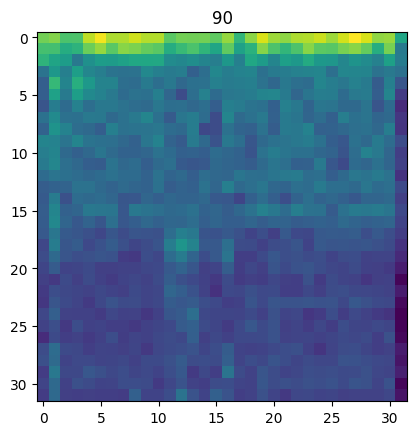

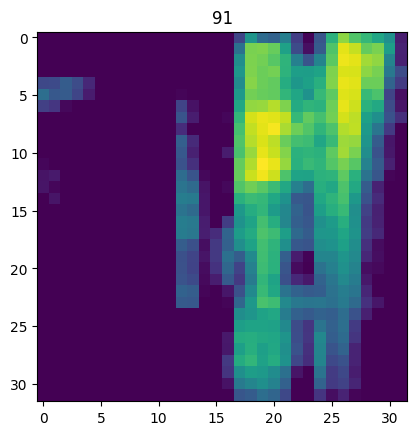

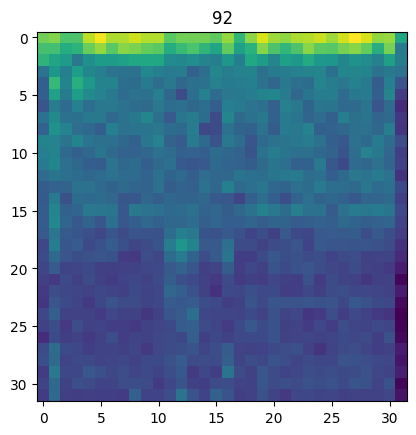

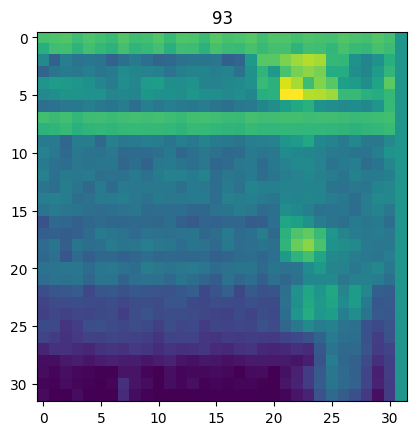

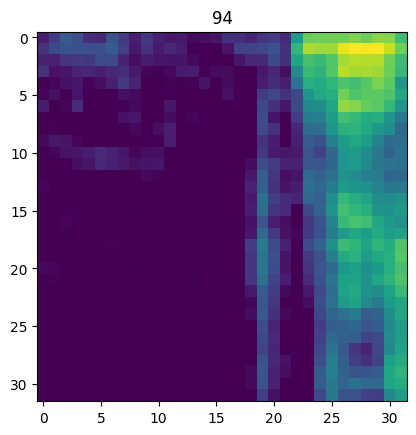

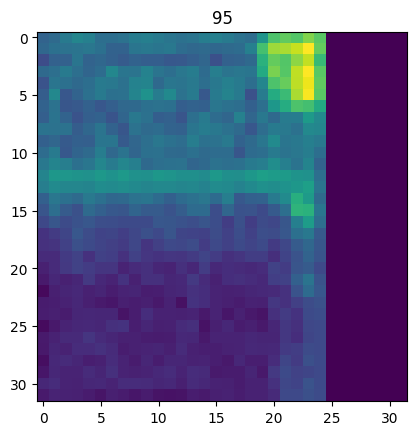

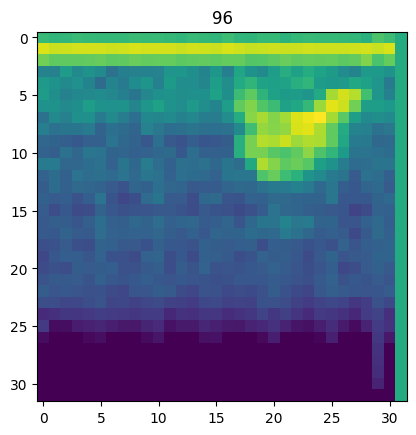

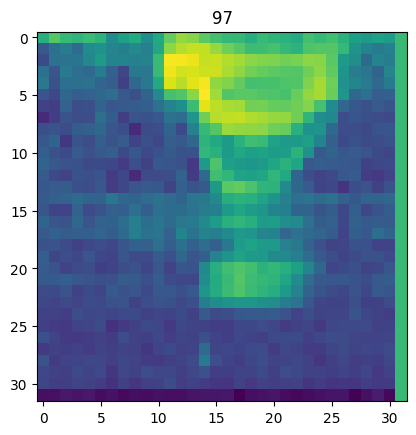

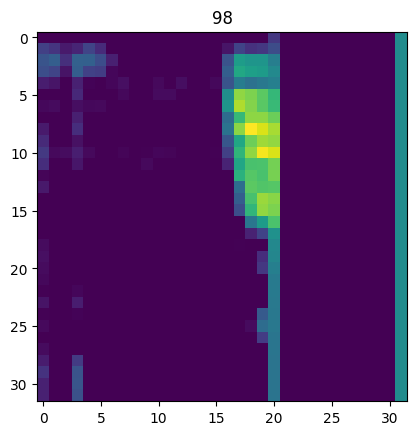

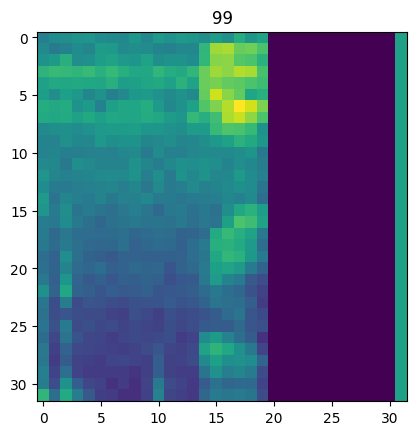

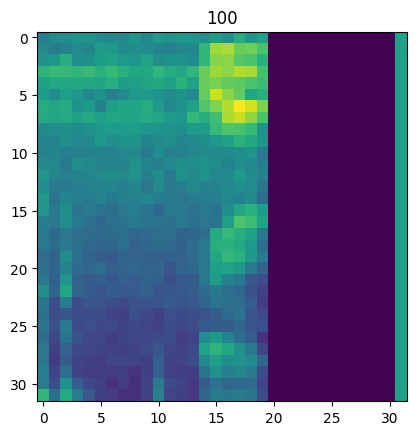

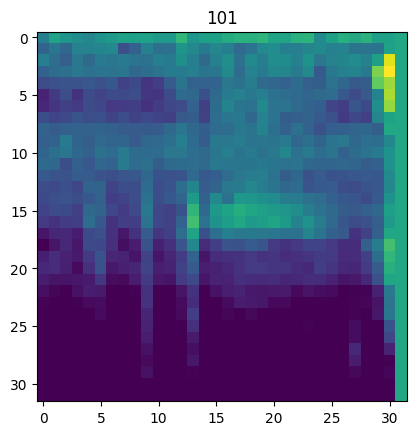

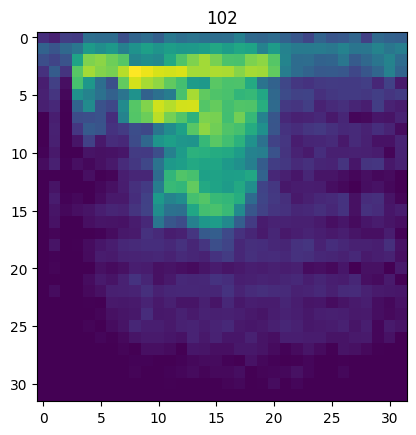

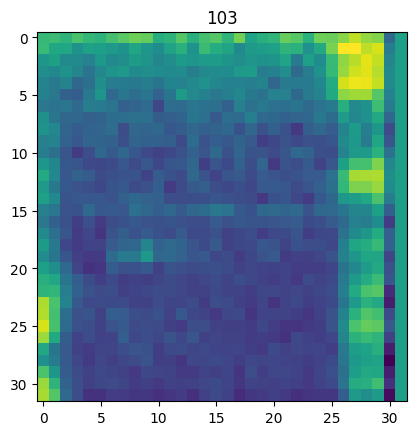

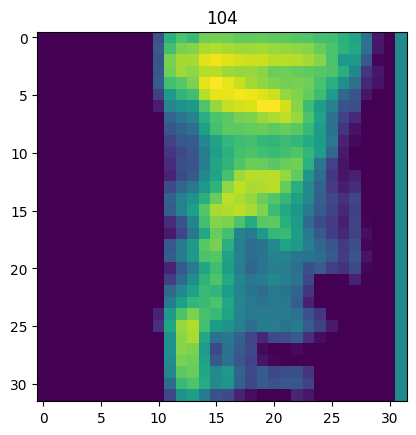

In [ ]:
for i in range(105):
    npy_protofull_50 = np.load(f'/content/drive/MyDrive/ProtoPNet/Mel/epoch-40/prototype-img{i}_FULL.npy')
    npy_protofull_50 = torch.Tensor(npy_protofull_50.tolist())
    plt.title(f"{i}")
    plt.imshow(npy_protofull_50)
    plt.show()

(32, 32, 1)


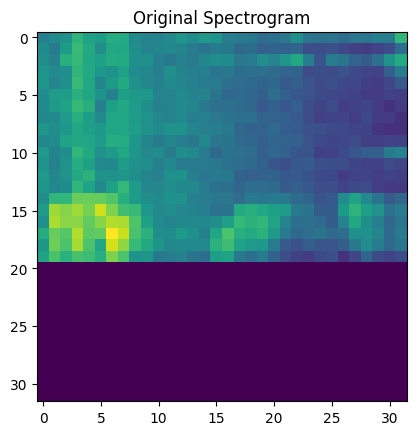

In [ ]:
npy_orginal_mel = np.load('/content/drive/MyDrive/ProtoPNet/Mel/epoch-40/prototype-img-original99.npy')
print(npy_orginal_mel.shape)
npy_orginal_mel = torch.from_numpy(npy_orginal_mel)
npy_protofull_mel_mod = npy_orginal_mel
npy_orginal_mel = torch.einsum('hwc->whc',npy_orginal_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('Original Spectrogram')
plt.imshow(npy_protofull_mel_mod)
plt.savefig('99__mel.pdf')
npy_protofull_mel_mod = torch.einsum('whc->chw',npy_protofull_mel_mod)
npy_protofull_mel_mod = npy_protofull_mel_mod.tolist()
npy_protofull_mel_mod = torch.Tensor(npy_protofull_mel_mod)
# # Perform the transform
waveform_spec = MelToWav()(npy_protofull_mel_mod)
Audio(waveform_spec.numpy(), rate=16000)

(32, 32, 1)


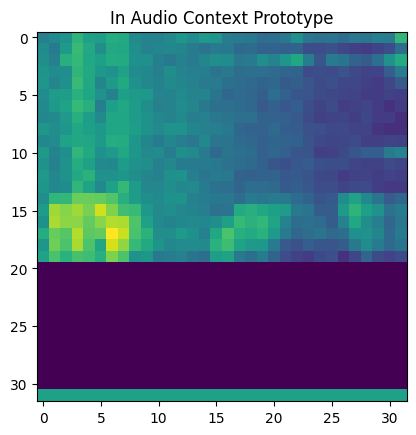

In [ ]:
npy_orginal_mel = np.load('/content/drive/MyDrive/ProtoPNet/Mel/epoch-40/prototype-img99_FULL.npy')
print(npy_orginal_mel.shape)
npy_orginal_mel = torch.from_numpy(npy_orginal_mel)
npy_protofull_mel_mod = npy_orginal_mel
npy_orginal_mel = torch.einsum('hwc->whc',npy_orginal_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('In Audio Context Prototype')
plt.imshow(npy_protofull_mel_mod)
plt.savefig('99_proto_mel_full.pdf')
npy_protofull_mel_mod = torch.einsum('whc->chw',npy_protofull_mel_mod)
npy_protofull_mel_mod = npy_protofull_mel_mod.tolist()
npy_protofull_mel_mod = torch.Tensor(npy_protofull_mel_mod)
# # Perform the transform
waveform_spec = MelToWav()(npy_protofull_mel_mod)
Audio(waveform_spec.numpy(), rate=16000)

(32, 31, 1)


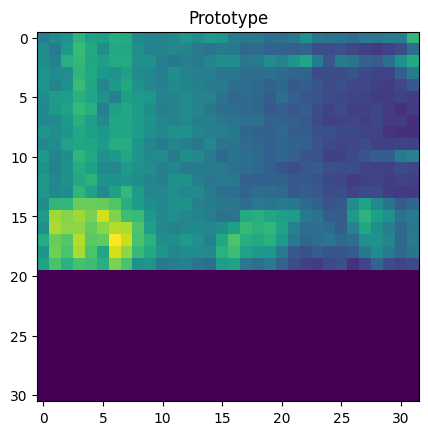

In [ ]:
npy_orginal_mel = np.load('/content/drive/MyDrive/ProtoPNet/Mel/epoch-40/prototype-img99.npy')
print(npy_orginal_mel.shape)
npy_orginal_mel = torch.from_numpy(npy_orginal_mel)
npy_protofull_mel_mod = npy_orginal_mel
npy_orginal_mel = torch.einsum('hwc->whc',npy_orginal_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('Prototype')
plt.imshow(npy_protofull_mel_mod)
plt.savefig('99_proto_mel.pdf')
npy_protofull_mel_mod = torch.einsum('whc->chw',npy_protofull_mel_mod)
npy_protofull_mel_mod = npy_protofull_mel_mod.tolist()
npy_protofull_mel_mod = torch.Tensor(npy_protofull_mel_mod)
# # Perform the transform
waveform_spec = MelToWav()(npy_protofull_mel_mod)
Audio(waveform_spec.numpy(), rate=16000)

(32, 31, 1)


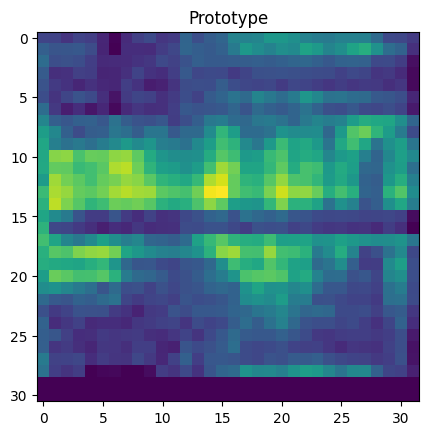

In [ ]:
npy_orginal_spec = np.load('/content/drive/MyDrive/ProtoPNet/Mel/epoch-40/prototype-img38.npy')
print(npy_orginal_spec.shape)
npy_orginal_spec = torch.from_numpy(npy_orginal_spec)
npy_orginal_spec = torch.einsum('hwc->whc',npy_orginal_spec)
plt.title('In Audio Context Prototype')
# npy_orginal_spec = torch.rot90(npy_orginal_spec)
# npy_orginal_spec = torch.rot90(npy_orginal_spec)
# npy_orginal_spec = torch.rot90(npy_orginal_spec)
# npy_orginal_spec = torch.fliplr(npy_orginal_spec)
plt.imshow(npy_orginal_spec)
plt.title('Prototype')
plt.imshow(npy_orginal_spec)
plt.savefig('38_mel_proto.pdf')
npy_orginal_spec = torch.einsum('whc->chw',npy_orginal_spec)
# # Perform the transform

# Conversion from just spectrograms

In [ ]:
class WavToSpec(torch.nn.Module):
    def __init__(
        self,
        n_fft=1024,
    ):
        super().__init__()

        self.spec = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=4)

    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        spec = self.spec(waveform)
        spec = torch.from_numpy(librosa.power_to_db(spec))

        return spec

In [ ]:
class SpecToWav(torch.nn.Module):
    def __init__(
        self,
        input_freq=16000,
        resample_freq=16000,
        n_fft=1024,
        n_mel=32,
        stretch_factor=0.8,
    ):
        super().__init__()
        self.inversespec = torchaudio.transforms.GriffinLim(n_fft)

    def forward(self, spec: torch.Tensor) -> torch.Tensor:
        inversespec = librosa.db_to_power(spec)
        waveform = self.inversespec(inversespec)

        return waveform

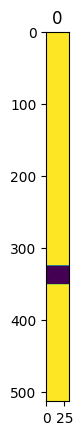

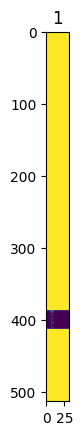

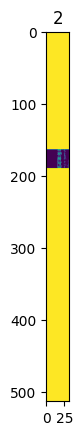

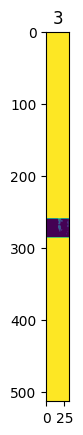

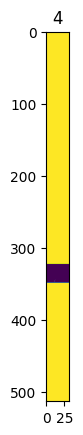

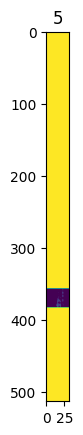

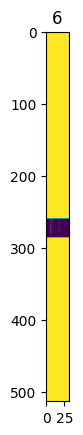

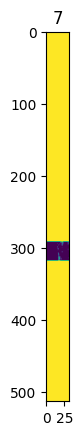

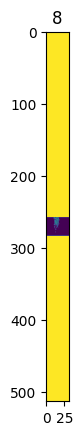

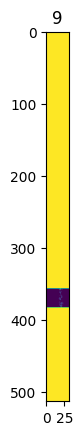

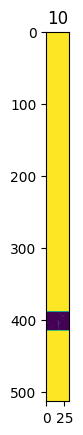

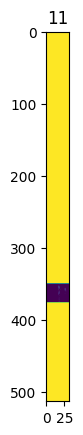

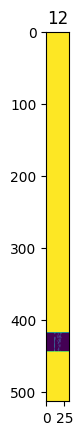

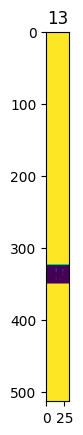

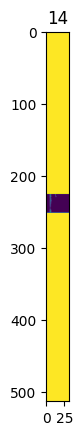

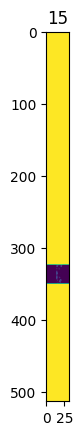

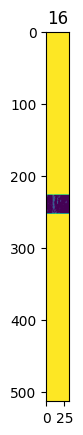

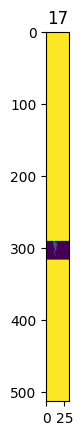

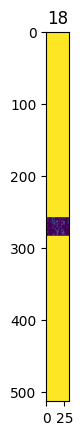

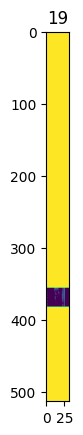

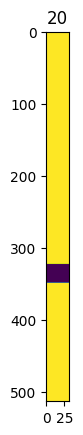

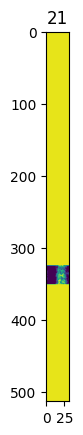

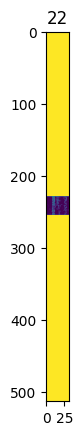

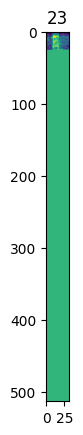

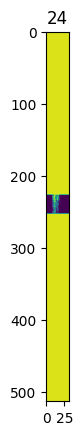

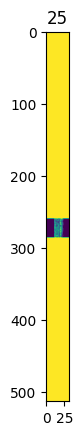

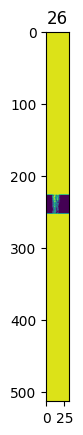

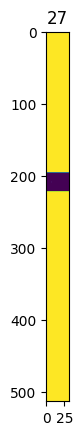

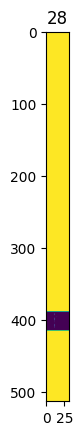

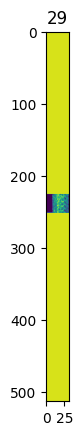

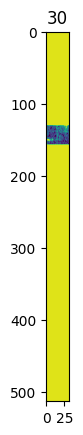

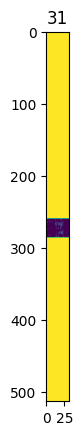

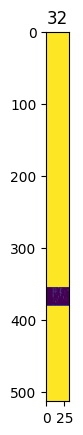

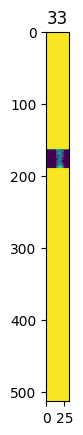

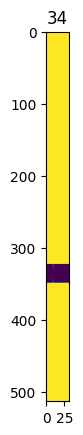

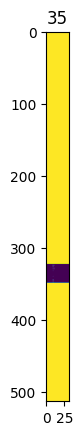

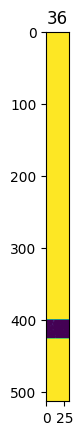

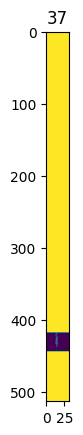

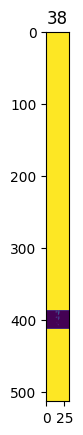

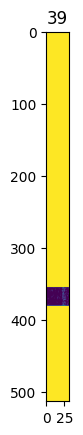

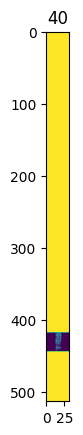

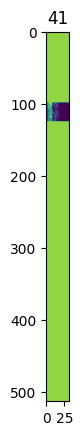

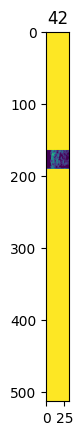

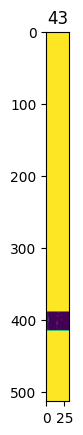

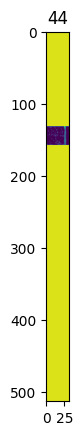

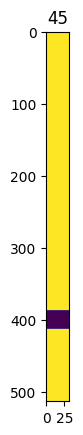

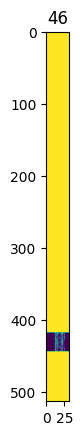

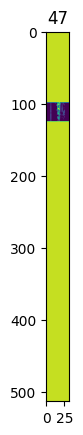

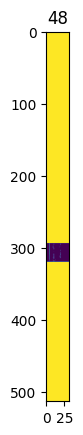

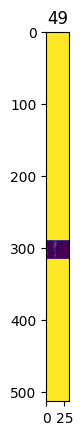

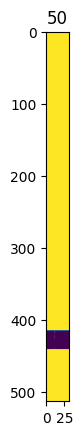

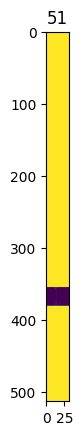

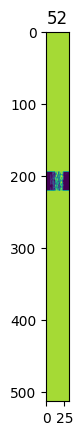

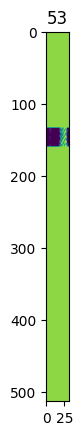

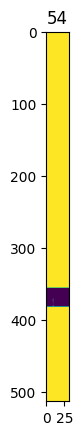

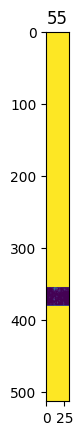

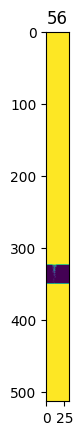

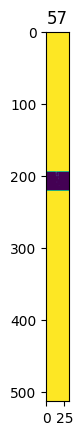

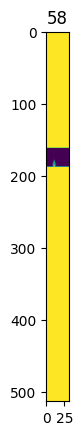

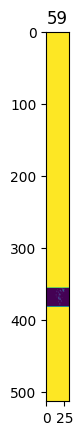

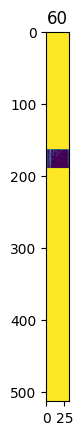

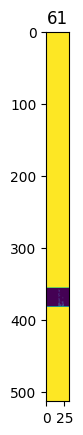

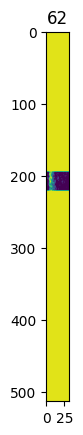

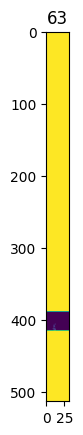

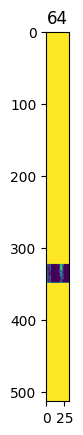

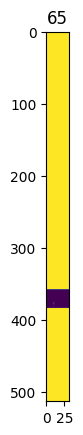

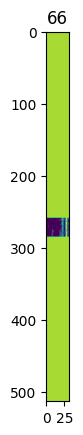

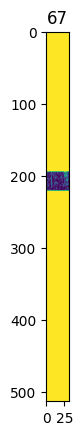

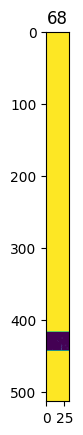

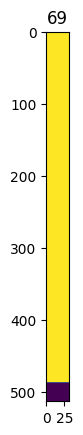

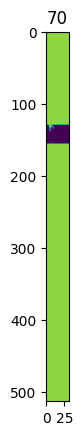

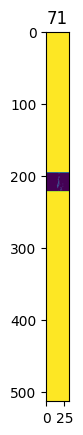

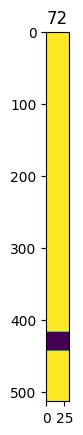

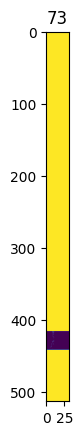

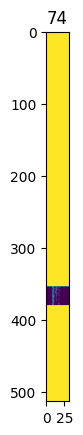

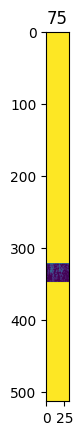

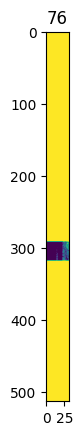

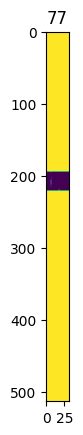

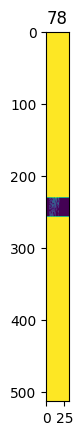

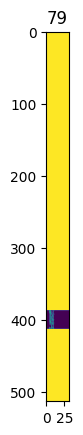

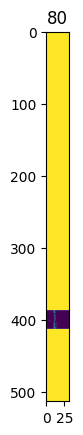

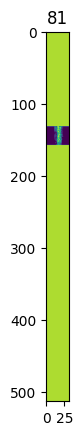

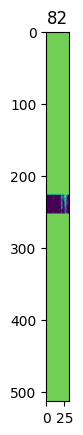

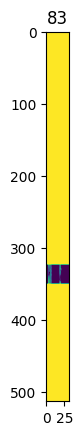

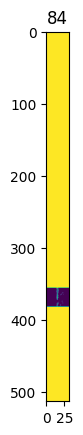

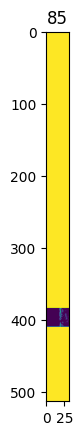

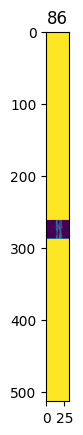

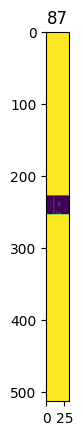

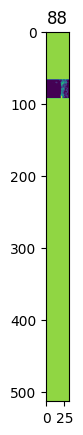

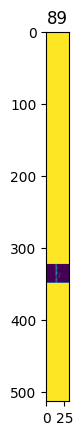

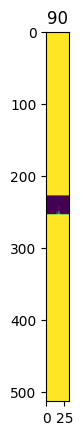

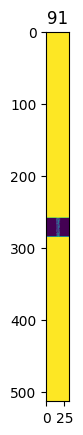

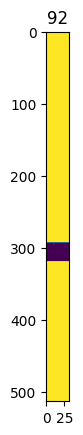

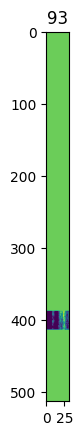

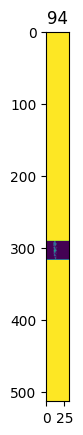

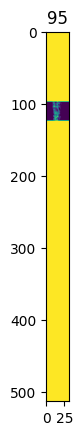

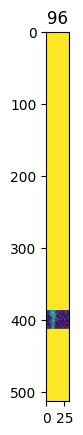

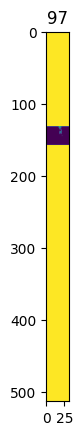

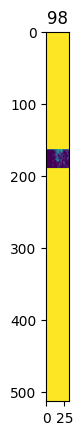

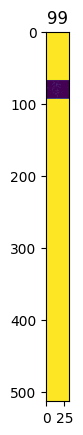

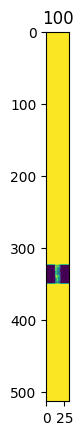

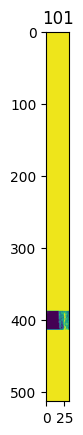

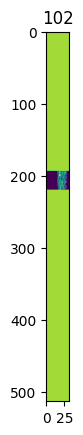

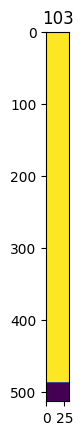

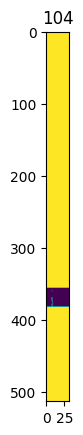

In [ ]:
for i in range(105):
    npy_protofull_50 = np.load(f'/content/drive/MyDrive/ProtoPNet/epoch_40_spec/epoch-40/prototype-img{i}_FULL.npy')
    npy_protofull_50 = torch.Tensor(npy_protofull_50.tolist())
    plt.title(f"{i}")
    plt.imshow(npy_protofull_50)
    plt.show()

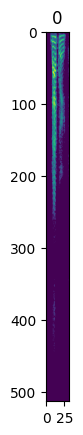

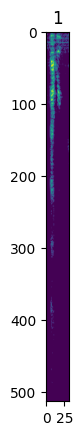

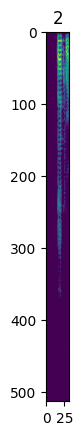

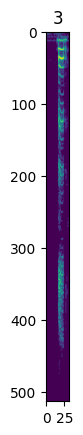

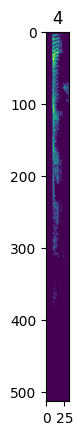

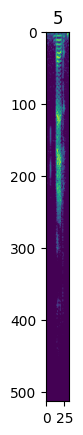

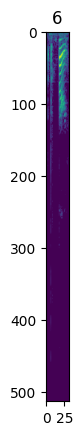

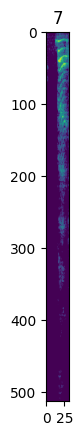

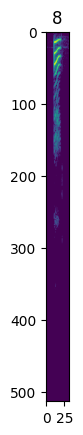

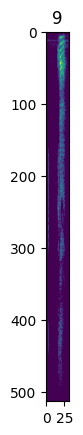

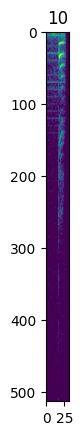

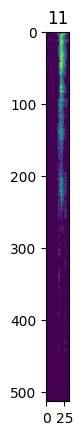

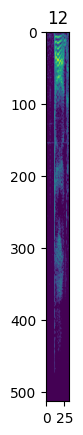

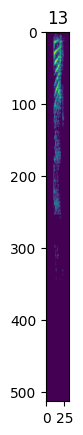

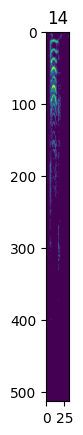

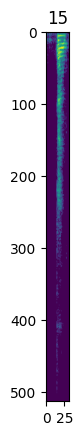

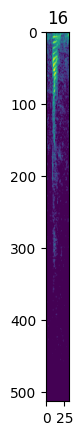

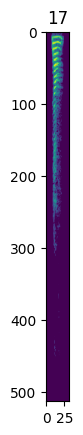

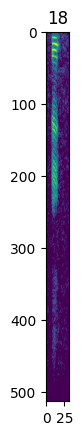

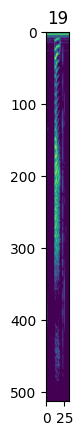

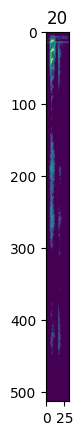

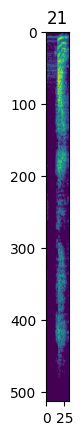

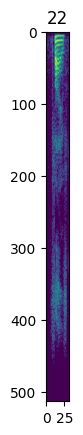

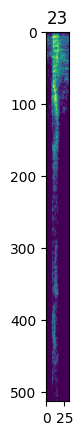

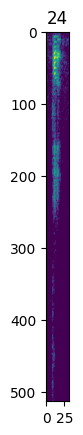

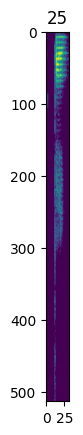

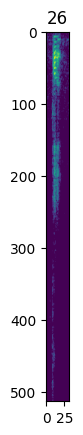

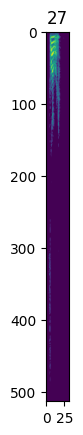

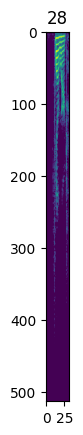

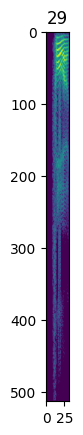

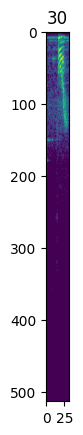

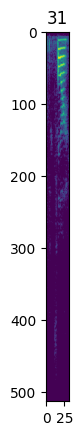

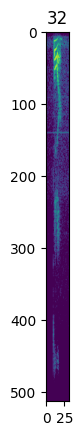

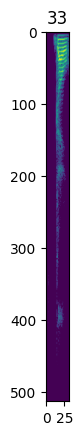

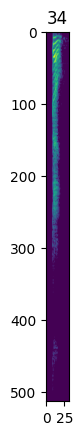

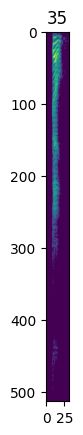

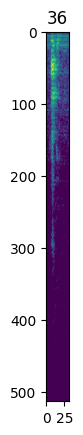

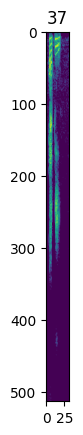

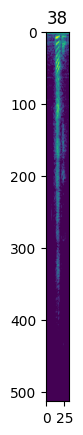

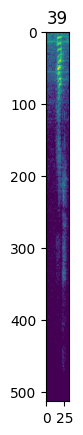

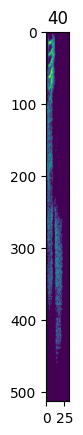

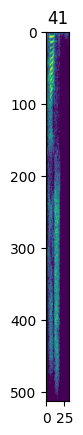

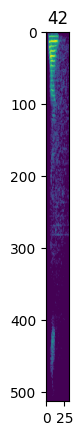

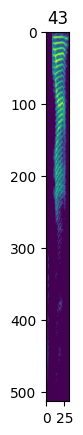

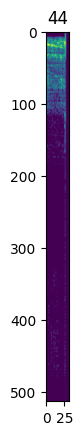

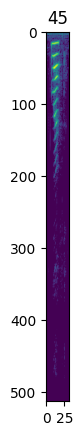

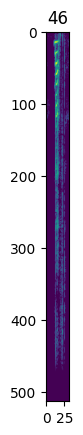

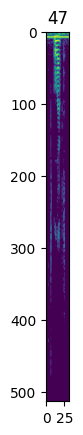

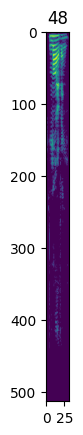

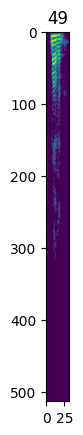

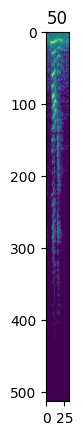

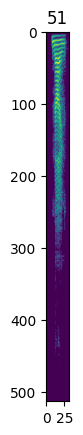

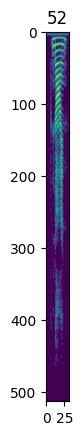

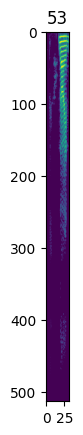

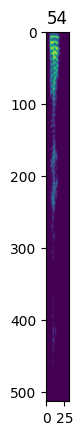

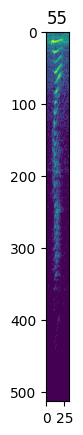

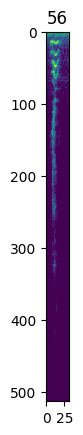

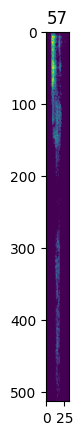

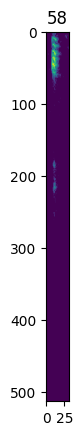

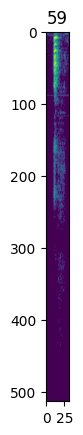

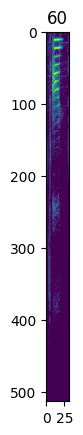

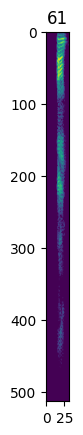

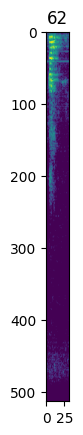

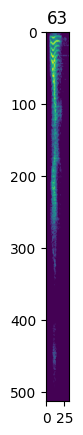

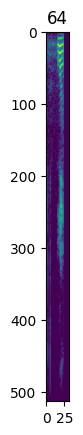

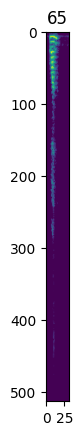

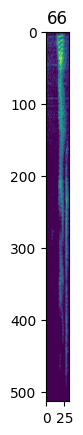

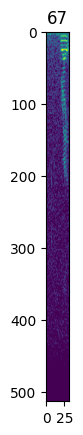

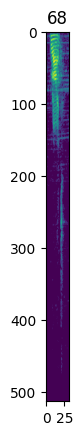

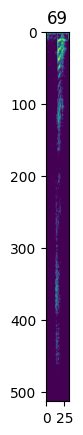

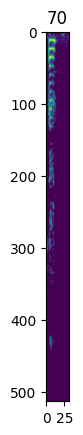

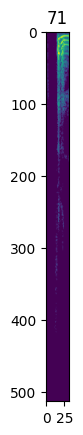

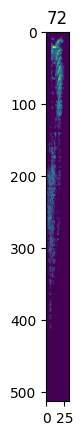

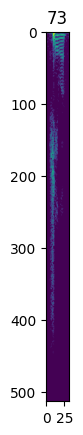

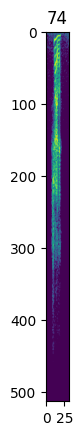

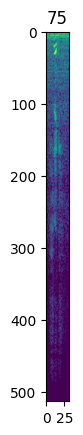

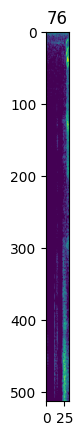

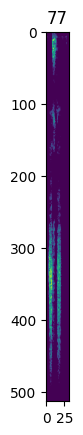

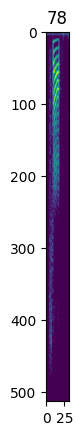

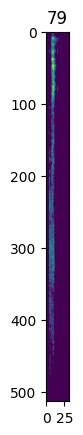

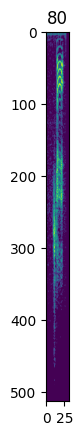

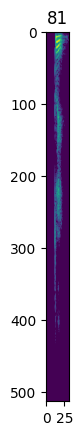

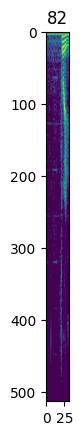

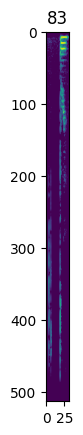

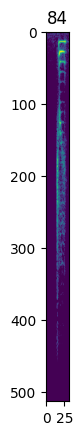

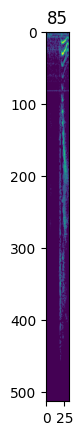

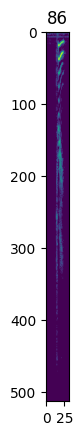

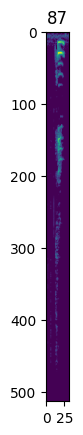

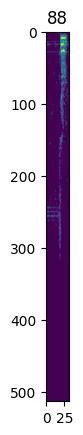

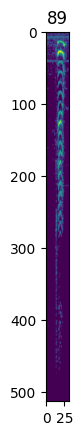

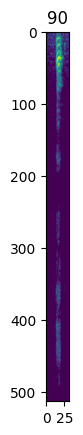

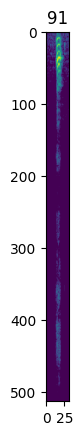

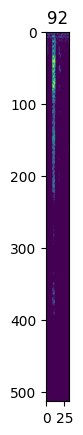

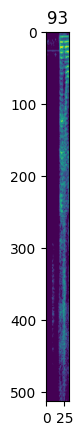

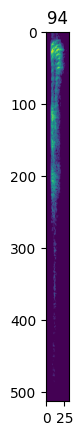

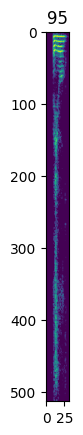

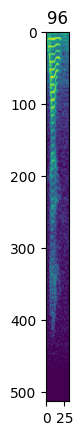

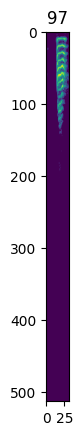

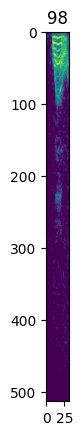

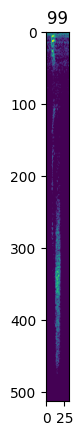

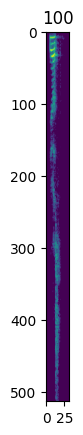

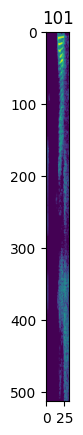

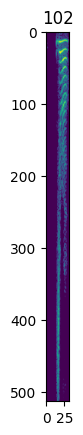

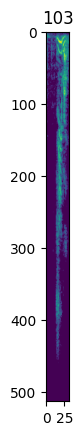

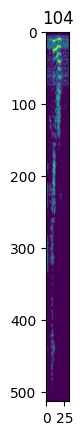

In [ ]:
for i in range(105):
    npy_protofull_50 = np.load(f'/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img-original{i}.npy')
    npy_protofull_50 = torch.Tensor(npy_protofull_50.tolist())
    plt.title(f"{i}")
    plt.imshow(npy_protofull_50)
    plt.show()

# Testing on Prototype FULL

(513, 32, 1)


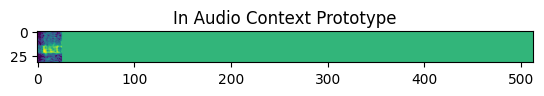

In [ ]:
npy_protofull_mel = np.load('/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img23_FULL.npy')
print(npy_protofull_mel.shape)
npy_protofull_mel = torch.from_numpy(npy_protofull_mel)
plt.imshow(npy_protofull_mel)
npy_protofull_mel_mod = torch.where(npy_protofull_mel==0,-999999, npy_protofull_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('In Audio Context Prototype')
npy_protofull_mel = torch.rot90(npy_protofull_mel)
npy_protofull_mel = torch.rot90(npy_protofull_mel)
npy_protofull_mel = torch.rot90(npy_protofull_mel)
npy_protofull_mel = torch.flip(npy_protofull_mel,[0,1])
plt.imshow(npy_protofull_mel)

# plt.savefig('38_mel_proto_full.pdf')
# # plt.imshow(npy_protofull_mel_mod)
# # # Perform the transform
npy_protofull_mel = npy_protofull_mel_mod.tolist()
npy_protofull_mel = torch.Tensor(npy_protofull_mel)
npy_protofull_mel =  torch.einsum('chw->wch',npy_protofull_mel)
waveform_spec = SpecToWav()(npy_protofull_mel)
Audio(waveform_spec.numpy(), rate=16000)

(513, 32, 1)


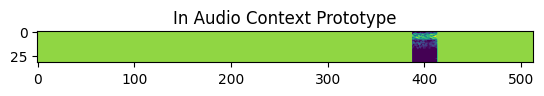

In [ ]:
npy_protofull_mel = np.load('/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img41_FULL.npy')
print(npy_protofull_mel.shape)
npy_protofull_mel = torch.from_numpy(npy_protofull_mel)
plt.imshow(npy_protofull_mel)
npy_protofull_mel_mod = torch.where(npy_protofull_mel==0,-999999, npy_protofull_mel)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
npy_protofull_mel_mod = torch.einsum('hwc->whc',npy_protofull_mel_mod)
plt.title('In Audio Context Prototype')
npy_protofull_mel = torch.rot90(npy_protofull_mel)
npy_protofull_mel = torch.rot90(npy_protofull_mel)
npy_protofull_mel = torch.rot90(npy_protofull_mel)
# npy_protofull_mel = torch.fliplr(npy_protofull_mel)

plt.imshow(npy_protofull_mel)

plt.savefig('38_mel_proto_full.pdf')
# plt.imshow(npy_protofull_mel_mod)
# # Perform the transform
npy_protofull_mel = npy_protofull_mel_mod.tolist()
npy_protofull_mel = torch.Tensor(npy_protofull_mel)
npy_protofull_mel =  torch.einsum('chw->wch',npy_protofull_mel)
waveform_spec = SpecToWav()(npy_protofull_mel)
Audio(waveform_spec.numpy(), rate=16000)

(513, 32, 1)


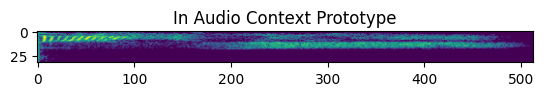

In [ ]:
npy_protofull_spec = np.load('/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img-original41.npy')
print(npy_protofull_spec.shape)
npy_protofull_spec = torch.from_numpy(npy_protofull_spec)
plt.imshow(npy_protofull_spec)
npy_protofull_spec_mod = torch.where(npy_protofull_spec==0, -150, npy_protofull_spec)
npy_protofull_spec = torch.einsum('hwc->whc',npy_protofull_spec)
npy_protofull_spec_mod = torch.einsum('hwc->whc',npy_protofull_spec_mod)
plt.title('In Audio Context Prototype')
plt.imshow(npy_protofull_spec)
plt.savefig('41_proto_full.pdf')
npy_protofull_spec_mod = torch.einsum('whc->chw',npy_protofull_spec_mod)
# # Perform the transform
waveform_90 = SpecToWav()(npy_protofull_spec_mod)
Audio(waveform_90.numpy(), rate=16000)

(513, 32, 1)


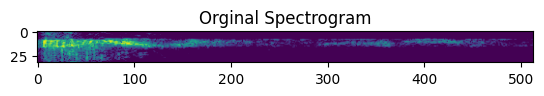

In [ ]:
npy_orginal_spec = np.load('/content/drive/MyDrive/ProtoPNet/Spec/epoch_40_spec/epoch-40/prototype-img-original23.npy')
print(npy_orginal_spec.shape)
npy_orginal_spec = torch.from_numpy(npy_orginal_spec)
npy_orginal_spec = torch.einsum('hwc->whc',npy_orginal_spec)
plt.title('Orginal Spectrogram')
plt.imshow(npy_orginal_spec)
plt.savefig('47_full.pdf')
npy_orginal_spec = torch.einsum('whc->chw',npy_orginal_spec)
# # Perform the transform
waveform_spec = SpecToWav()(npy_orginal_spec)
Audio(waveform_spec.numpy(), rate=16000)

torch.Size([1, 513, 32])


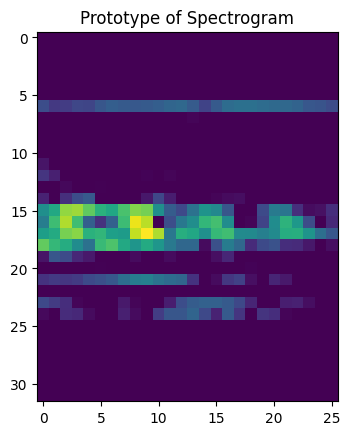

In [ ]:
npy_proto_spec = np.load('/content/drive/MyDrive/ProtoPNet/epoch_40_spec/epoch-40/prototype-img47.npy')
print(npy_orginal_spec.shape)
npy_proto_spec = torch.from_numpy(npy_proto_spec)
npy_proto_spec = torch.einsum('hwc->whc',npy_proto_spec)
plt.title('Prototype of Spectrogram')
plt.imshow(npy_proto_spec)
plt.savefig('47_proto.pdf')

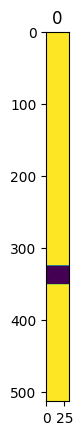

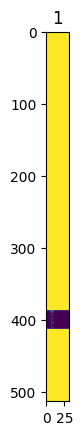

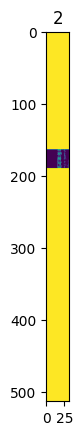

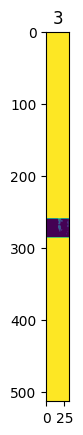

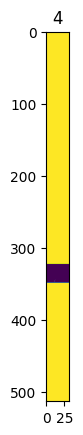

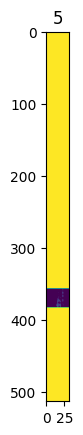

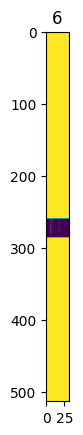

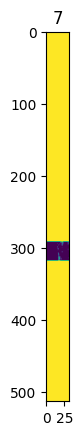

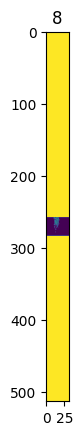

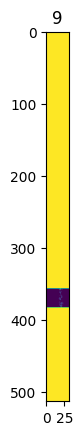

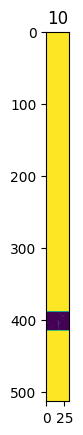

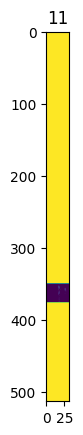

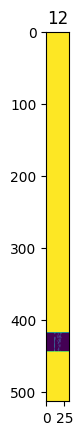

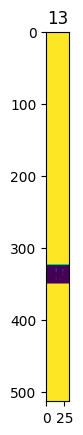

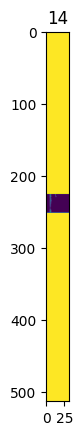

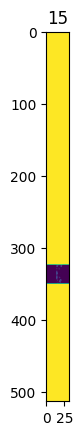

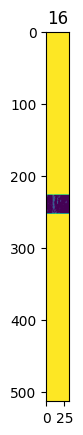

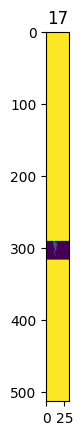

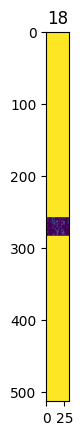

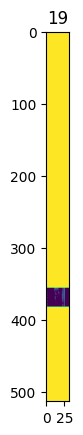

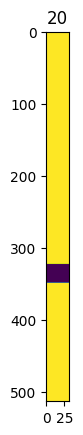

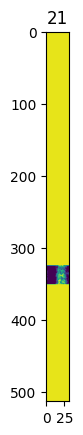

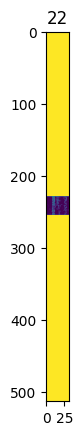

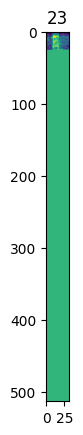

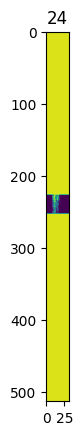

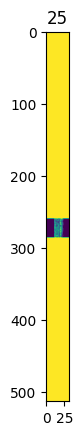

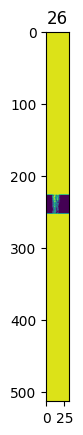

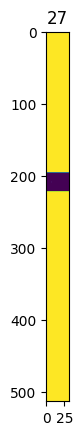

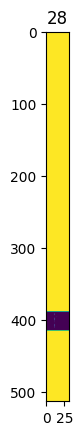

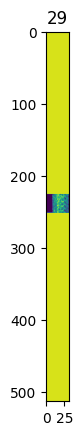

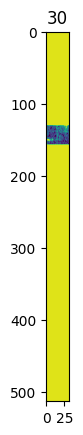

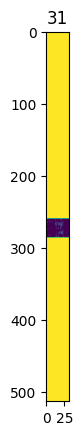

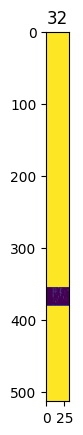

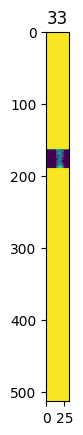

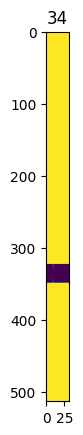

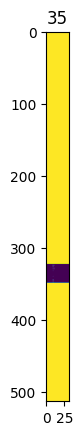

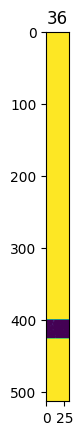

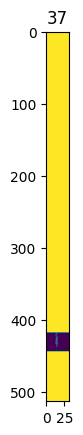

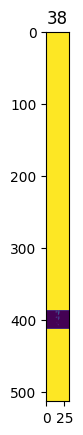

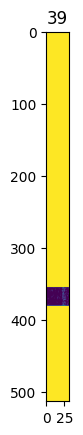

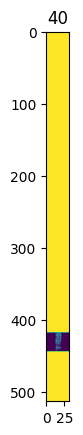

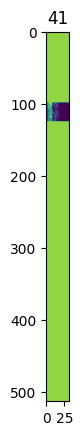

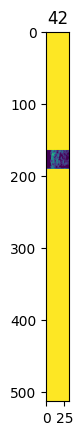

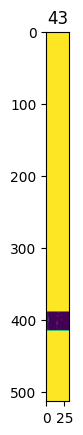

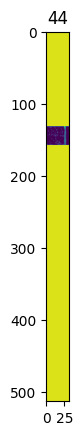

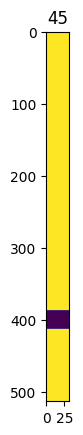

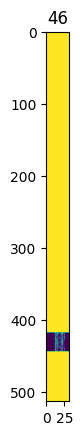

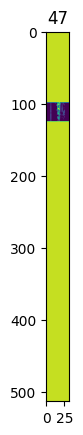

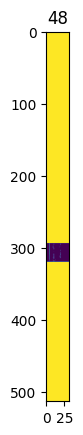

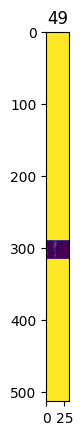

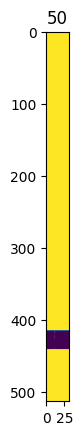

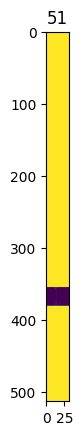

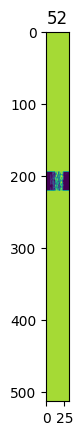

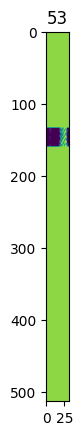

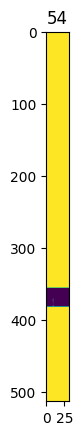

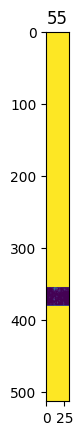

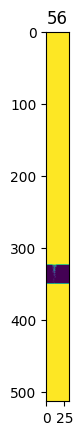

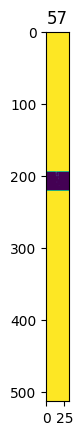

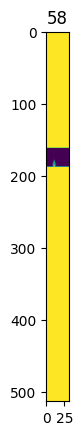

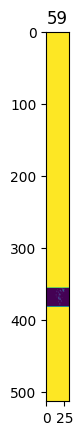

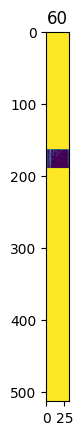

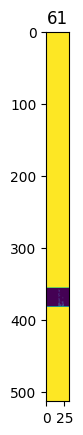

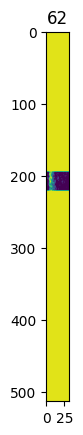

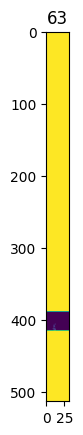

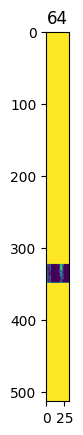

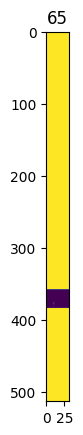

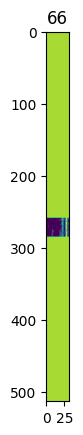

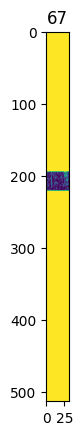

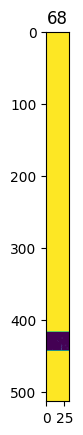

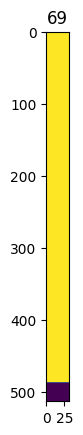

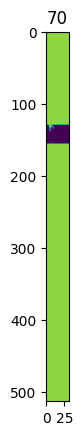

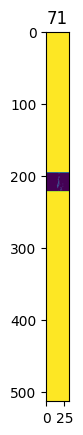

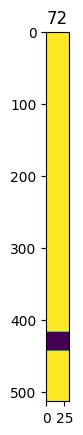

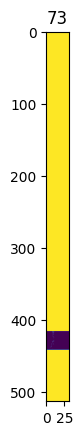

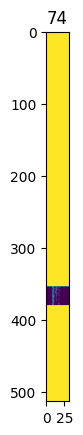

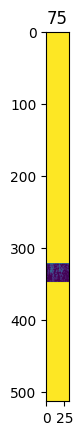

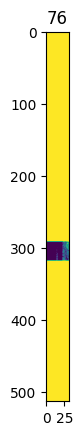

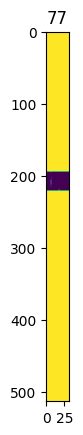

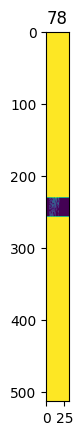

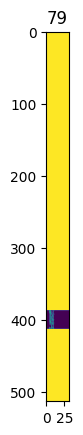

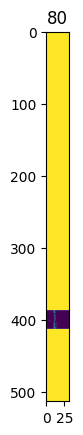

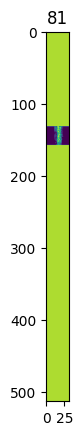

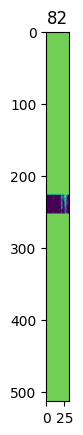

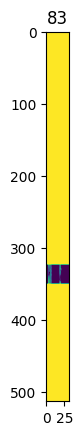

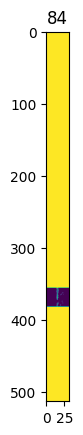

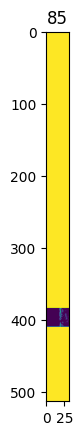

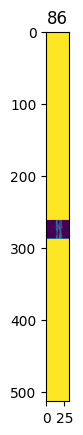

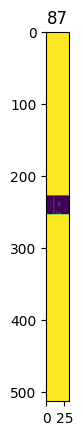

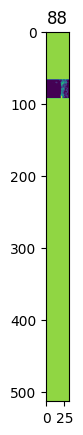

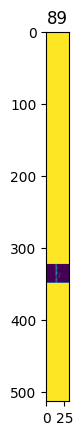

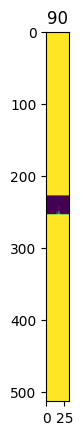

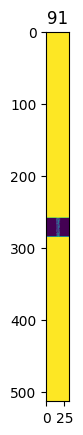

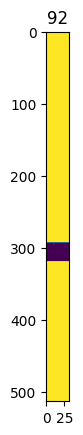

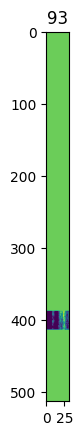

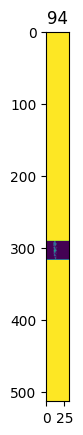

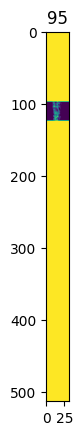

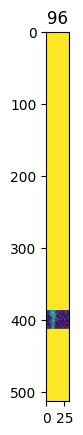

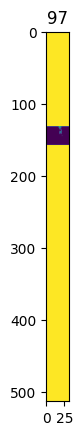

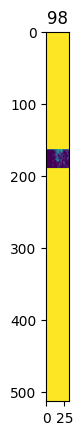

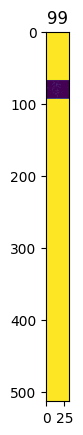

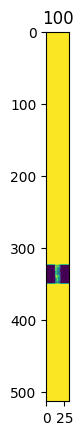

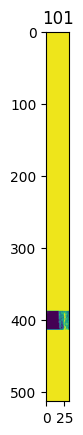

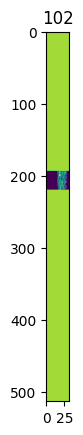

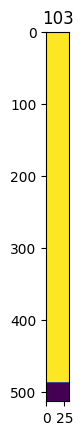

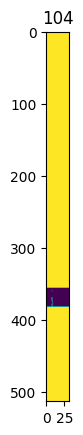

In [ ]:
for i in range(105):
    npy_protofull_50 = np.load(f'/data/home/acw782/SCRATCH/ProtoPNet/saved_models/vgg11/10_aug_no_noise/img/epoch-40/prototype-img{i}_FULL.npy')
    npy_protofull_50 = torch.Tensor(npy_protofull_50.tolist())
    plt.title(f"{i}")
    plt.imshow(npy_protofull_50)
    plt.show()
# npy_protofull_90 = torch.einsum('hwc->chw',npy_protofull_90)
# # Perform the transform
# waveform_proto_90 = mel_to_wav(npy_protofull_90)
# Audio(waveform_proto_90.numpy(), rate=16000)

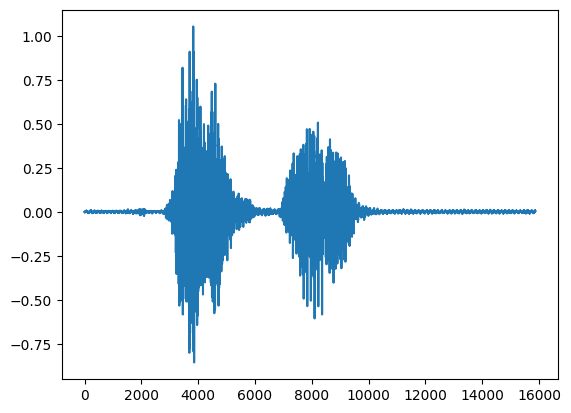

In [ ]:
plt.plot(waveform_90.reshape(-1))